# Projet d’aide à la décision immobilière
## Sélection multi-critères de biens immobiliers à partir des données DVF

Ce notebook met en œuvre une démarche d’aide multicritère à la décision (AMC) pour sélectionner des investissements locatifs en Île‑de‑France à partir des données DVF (transactions immobilières) et de la carte des loyers (DHUP).  
L’objectif est de construire une famille de critères financiers et de marché, puis d’agréger ces critères avec la méthode ELECTRE III afin d’identifier un petit ensemble de projets particulièrement intéressants pour un investisseur locatif.

## Objectif

L’objectif est de construire un modèle d’aide à la décision pour sélectionner des biens immobiliers d’investissement selon plusieurs critères :
- Rentabilité
- Cash-flow
- Prix au m²
- Tension locative
- DPE (approché)
- Risque travaux
- Indice de quartier
- Liquidité
- Temps de transport
- Potentiel de valorisation

Certaines variables non présentes dans DVF sont approchées par des indicateurs synthétiques afin de conserver une cohérence décisionnelle.


## 1. Imports et configuration

Cette section charge les bibliothèques nécessaires (pandas, numpy, matplotlib, seaborn) et fixe quelques options d’affichage pour faciliter l’exploration des données et la visualisation des résultats.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import unicodedata
import os

#Affichages
pd.set_option("display.max_columns", 50)
pd.set_option("display.precision", 2)
warnings.filterwarnings("ignore")

#Graphiques
try:
    plt.style.use("seaborn-v0_8-darkgrid")
except OSError:
    plt.style.use("default")
    sns.set_style("darkgrid")

sns.set_palette("husl")

# Param globaux
IDF_DEPTS = {"75", "77", "78", "91", "92", "93", "94", "95"}

PARAMS_FINANCE = {
    "charges_ratio": 0.15,   # 15% du loyer annuel
    "taux_annuel": 0.04,     # coût annuel du financement (4%)
}

MAX_ACTIONS_FOR_ELECTRE = 800  # Limite pour éviter une matrice trop grande

## 2. Chargement et pré‑traitement des données DVF

On charge le fichier DVF brut (transactions immobilières) pour le semestre 2025 S1.  
Les filtres appliqués sont volontairement simples :  
- restriction aux mutations de type “Vente” ;  
- élimination des lignes sans prix ou sans surface bâtie ;  
- suppression des valeurs négatives ou nulles.  

L’objectif est d’obtenir un jeu de données propre sur lequel construire les actions (biens) du modèle.


In [2]:
def load_dvf(path, chunksize=50000):
    """Charge et nettoie les données DVF par chunks"""
    #print(f"Chargement par chunks ({chunksize:,} lignes)...")
    cols_keep = [
        "Identifiant de document", "Date mutation", "Nature mutation",
        "Valeur fonciere", "Surface reelle bati", "Surface terrain",
        "Nombre pieces principales", "Type local", "Commune",
        "Code postal", "Code commune", "Code departement"
    ]
    chunks_clean = []
    total_raw = total_keep = 0

    try:
        reader = pd.read_csv(path, sep="|", low_memory=False, engine="c",
                            chunksize=chunksize, encoding="latin1")
    except Exception as e:
        print(f"Erreur: {e}")
        return pd.DataFrame()

    for i, chunk in enumerate(reader, start=1):
        total_raw += len(chunk)
        chunk.columns = [c.strip() for c in chunk.columns]
        #On sélectionne les colonnes + filtre ventes
        cols_here = [c for c in cols_keep if c in chunk.columns]
        chunk = chunk[cols_here].copy()
        if "Nature mutation" in chunk.columns:
            chunk = chunk[chunk["Nature mutation"]== "Vente"]
        # Conversion valeur foncière
        if "Valeur fonciere" in chunk.columns:
            chunk["Valeur fonciere"] = (chunk["Valeur fonciere"].astype(str)
                .str.replace(",", ".", regex=False).replace("nan", np.nan).astype(float))
        # prix > 0, surface > 0
        chunk = chunk.dropna(subset=["Valeur fonciere", "Surface reelle bati"])
        chunk = chunk[(chunk["Valeur fonciere"] > 0) & (chunk["Surface reelle bati"] > 0)]

        total_keep += len(chunk)
        chunks_clean.append(chunk)
        if i % 10 == 0:
            print(f"  {i} chunks traités...")

    if not chunks_clean:
        print("Aucun chunk utilisable")
        return pd.DataFrame()

    df = pd.concat(chunks_clean, ignore_index=True)
    print(f"{total_raw:,} → {total_keep:,} lignes ({df.shape[1]} colonnes)")
    return df


print("=" * 70)
print("CHARGEMENT DES DONNÉES DVF")
print("=" * 70)

df_raw = load_dvf("ValeursFoncieres-2025-S1.txt", chunksize=50_000)

if len(df_raw) > 0:
    print(f"\n {len(df_raw):,} transactions chargées")
    print(f"Valeur moyenne: {df_raw['Valeur fonciere'].mean():,.0f} €")
    print(f"Surface moyenne: {df_raw['Surface reelle bati'].mean():.1f} m²")
else:
    print("Aucune donnée utilisable")

df_raw.head()

CHARGEMENT DES DONNÉES DVF


  10 chunks traités...
  20 chunks traités...
1,387,077 → 441,054 lignes (12 colonnes)

 441,054 transactions chargées
Valeur moyenne: 829,592 €
Surface moyenne: 115.8 m²


,Identifiant de document,Date mutation,Nature mutation,Valeur fonciere,Surface reelle bati,Surface terrain,Nombre pieces principales,Type local,Commune,Code postal,Code commune,Code departement
0,NaN,07/01/2025,Vente,468000.0,111.0,133.0,5.0,Maison,FARGES,1550.0,158,1
1,NaN,06/01/2025,Vente,180000.0,87.0,76.0,4.0,Appartement,MONTANGES,1200.0,257,1
2,NaN,06/01/2025,Vente,490000.0,190.0,500.0,6.0,Maison,BUELLAS,1310.0,65,1
3,NaN,06/01/2025,Vente,490000.0,190.0,2452.0,6.0,Maison,BUELLAS,1310.0,65,1
4,NaN,09/01/2025,Vente,183000.0,35.0,NaN,2.0,Appartement,GEX,1170.0,173,1


In [4]:
# Cellule 2bis - Chargement table de codes postaux INSEE
print("Chargement table INSEE...")

try:
    cp_insee = pd.read_csv("base-officielle-codes-postaux.csv", dtype=str)
    print(f"  Chargee: {len(cp_insee):,} lignes")
except FileNotFoundError:
    print("  ERREUR: base-officielle-codes-postaux.csv non trouve")
    cp_insee = pd.DataFrame()

if not cp_insee.empty:
    # Nettoyer
    def _strip_accents(x):
        if pd.isna(x):
            return ""
        return unicodedata.normalize("NFKD", str(x)).encode("ascii", errors="ignore").decode("ascii")
    
    cp_insee["code_postal"] = cp_insee["code_postal"].astype(str).str.zfill(5)
    cp_insee["nom_commune_clean"] = (
        cp_insee["nom_de_la_commune"].map(_strip_accents).str.upper()
        .str.replace(r"[^A-Z0-9\s\-]", "", regex=True).str.strip()
    )
    cp_insee["code_commune_insee"] = cp_insee["code_commune_insee"].astype(str).str.zfill(5)
    
    # Créer map
    cp_insee_idf = cp_insee[["code_postal", "nom_commune_clean", "code_commune_insee"]].drop_duplicates()
    print(f"  INSEE: {len(cp_insee_idf):,} entrees")
else:
    print("  AVERTISSEMENT: table INSEE vide")
    cp_insee_idf = pd.DataFrame(columns=["code_postal", "nom_commune_clean", "code_commune_insee"])

Chargement table INSEE...
  Chargee: 39,192 lignes
  INSEE: 35,511 entrees


## 3. Construction des actions immobilières

Les transactions DVF sont agrégées au niveau de la “mutation” pour former des actions immobilières :  
- agrégation par identifiant de document, date de mutation et code commune ;  
- calcul du prix total, de la surface bâtie totale, du nombre de pièces, du type de local, etc.  

Chaque action correspond à un bien immobilier résidentiel (appartement ou maison) qui sera évalué multicritère.


In [5]:
def build_actions(df, dedup_strategy='best_price', min_price=10_000, min_surface=10):
    """Construit les actions en agrégeant les transactions DVF."""
    print(f"Construction actions: {len(df):,} transactions")
    df = df.copy()

    # Validation colonnes requises
    required = ["Identifiant de document", "Date mutation", "Code commune", "Valeur fonciere", "Surface reelle bati"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Colonnes manquantes: {missing}")

    # Création action_id
    df["action_id"] = (
        df["Identifiant de document"].astype(str).str.strip() + "_" +
        df["Date mutation"].astype(str).str.strip() + "_" +
        df["Code commune"].astype(str).str.strip()
    )

    unique_ids = df["action_id"].nunique()
    total_rows = len(df)
    duplication_ratio = (total_rows - unique_ids) / total_rows * 100
    print(f"  Mutations: {total_rows:,} | Uniques: {unique_ids:,} | Doublons: {duplication_ratio:.1f}%")

    # Déduplication
    if dedup_strategy == 'best_price':
        idx = df.groupby("action_id")["Valeur fonciere"].idxmax()
        df = df.loc[idx].reset_index(drop=True)
    elif dedup_strategy == 'latest_date':
        df["Date mutation"] = pd.to_datetime(df["Date mutation"], errors='coerce')
        idx = df.groupby("action_id")["Date mutation"].idxmax()
        df = df.loc[idx].reset_index(drop=True)
    else:
        df = df.drop_duplicates(subset=["action_id"], keep='first')

    deduplicated_count = len(df)

    # Agrégation
    agg_rules = {
        "Valeur fonciere": "first",
        "Surface reelle bati": "sum",
        "Surface terrain": "sum" if "Surface terrain" in df.columns else None,
        "Nombre pieces principales": "max" if "Nombre pieces principales" in df.columns else None,
        "Type local": lambda x: next((i for i in x if i not in ["Dépendance", "Local industriel. commercial ou assimilé", None]), "Inconnu"),
        "Commune": "first",
        "Code postal": "first",
        "Code commune": "first",
    }
    agg_rules = {k: v for k, v in agg_rules.items() if v is not None and k in df.columns}

    actions = df.groupby("action_id", as_index=False).agg(agg_rules)

    # Renommage
    rename_map = {
        "Valeur fonciere": "prix",
        "Surface reelle bati": "surface_batie",
        "Surface terrain": "surface_terrain",
        "Nombre pieces principales": "pieces",
        "Type local": "type_local",
        "Commune": "ville",
        "Code postal": "cp",
        "Code commune": "code_commune",
    }
    actions = actions.rename(columns={k: v for k, v in rename_map.items() if k in actions.columns})

    # Nettoyage code postal
    if "cp" in actions.columns:
        actions["cp_clean"] = (actions["cp"].astype(str)
            .str.replace(r"\.0$", "", regex=True).str.strip().str.zfill(5))

    # Nettoyage nom commune
    if "ville" in actions.columns:
        def _strip_accents(x):
            if pd.isna(x):
                return ""
            return unicodedata.normalize("NFKD", str(x)).encode("ascii", errors="ignore").decode("ascii")

        actions["ville_clean"] = (actions["ville"].map(_strip_accents).str.upper()
            .str.replace(r"[^A-Z0-9\s\-]", "", regex=True).str.strip())

    # Jointure INSEE
    try:
        _ = cp_insee_idf
    except NameError:
        raise NameError("cp_insee_idf non défini")

    before_merge = len(actions)
    actions = actions.merge(
        cp_insee_idf[["code_postal", "nom_commune_clean", "code_commune_insee"]],
        left_on=["cp_clean", "ville_clean"],
        right_on=["code_postal", "nom_commune_clean"],
        how="left",
    ).rename(columns={"code_commune_insee": "code_insee"})

    matched = actions["code_insee"].notna().sum()
    print(f"  INSEE: {matched:,}/{before_merge:,} ({matched/before_merge*100:.1f}%)")

    # Filtrage final
    actions = actions.dropna(subset=["prix", "surface_batie"])
    actions = actions[(actions["prix"] > min_price) & (actions["surface_batie"] > min_surface)]

    final_count = len(actions)
    print(f"  Final: {final_count:,} actions ({final_count/total_rows*100:.1f}% du total)")
    print(f"  Prix moyen: {actions['prix'].mean():,.0f} | Surface: {actions['surface_batie'].mean():.1f}m²")

    stats = {
        'total_input': total_rows,
        'unique_mutations': unique_ids,
        'duplicates_removed': total_rows - deduplicated_count,
        'duplication_ratio': duplication_ratio,
        'final_actions': final_count,
        'insee_matched': matched,
    }

    return actions, stats


actions, dedup_stats = build_actions(df_raw, dedup_strategy='best_price')
print(f"\nResultat: {len(actions):,} actions | {dedup_stats['duplicates_removed']:,} doublons supprimes")
actions.head()

Construction actions: 441,054 transactions
  Mutations: 441,054 | Uniques: 70,241 | Doublons: 84.1%
  INSEE: 46,320/70,241 (65.9%)
  Final: 69,962 actions (15.9% du total)
  Prix moyen: 544,988 | Surface: 180.3m²

Resultat: 69,962 actions | 370,813 doublons supprimes


,action_id,prix,surface_batie,surface_terrain,pieces,type_local,ville,cp,code_commune,cp_clean,ville_clean,code_postal,nom_commune_clean,code_insee
0,nan_01/01/2025_245,77800.0,97.0,789.0,5.0,Maison,ROQUEFORT,40120.0,245,40120,ROQUEFORT,40120,ROQUEFORT,40245
1,nan_01/01/2025_474,30000.0,79.0,603.0,3.0,Maison,SAUVIGNY,55140.0,474,55140,SAUVIGNY,55140,SAUVIGNY,55474
2,nan_01/02/2025_1,439800.0,150.0,1216.0,4.0,Maison,ABONDANT,28410.0,1,28410,ABONDANT,28410,ABONDANT,28001
3,nan_01/02/2025_10,385000.0,98.0,344.0,5.0,Maison,BONDY,93140.0,10,93140,BONDY,93140,BONDY,93010
4,nan_01/02/2025_101,182500.0,103.0,561.0,4.0,Maison,DOMERAT,3410.0,101,03410,DOMERAT,03410,DOMERAT,03101


## 4. Filtrage Île‑de‑France et nettoyage des actions

Cette section restreint le périmètre géographique à l’Île‑de‑France (via le code postal et, si disponible, le code département DVF).  
On applique ensuite un nettoyage ciblé :  
- sélection des seuls biens résidentiels (“Appartement”, “Maison”) ;  
- gestion des valeurs extrêmes sur le prix et la surface (winsorisation) ;  
- suppression des actions avec prix ou surface insuffisants.  

On obtient ainsi un ensemble d’actions IDF cohérent pour l’analyse.


In [59]:
# Cellule 4 - Filtrage et nettoyage IDF
def winsorize_series(s, low=0.01, high=0.99):
    """Limite les outliers aux percentiles."""
    return s.clip(s.quantile(low), s.quantile(high))


def filter_and_clean_actions(actions, idf_depts=None, min_surface=10, min_price=20_000, 
                              residential_only=True, winsorize_outliers=True):
    """Filtre et nettoie les actions."""
    print(f"Filtrage: {len(actions):,} actions")
    
    if actions is None or len(actions) == 0:
        raise ValueError("DataFrame vide")
    
    required = ["cp", "type_local", "prix", "surface_batie"]
    missing = [c for c in required if c not in actions.columns]
    if missing:
        raise ValueError(f"Colonnes manquantes: {missing}")
    
    if idf_depts is None:
        try:
            idf_depts = IDF_DEPTS
        except NameError:
            raise NameError("IDF_DEPTS non défini")
    
    a = actions.copy()
    
    # Filtrage géographique
    cp = a["cp"].astype(str).str.replace(r"\.0$", "", regex=True).str.replace(r"\s+", "", regex=True).str.zfill(5)
    a["cp_clean"] = cp
    a["dept_cp"] = a["cp_clean"].str[:2]
    
    if "Code departement" in a.columns:
        dep = a["Code departement"].astype(str).str.replace(r"\.0$", "", regex=True).str.strip().str.zfill(2)
        a["dept_dvf"] = dep
        keep_geo = a["dept_dvf"].isin(idf_depts) | a["dept_cp"].isin(idf_depts)
    else:
        keep_geo = a["dept_cp"].isin(idf_depts)
    
    before_geo = len(a)
    a = a[keep_geo].copy()
    removed_geo = before_geo - len(a)
    print(f"  IDF: {len(a):,} actions ({removed_geo:,} hors IDF)")
    
    # Filtrage type
    if residential_only:
        before_type = len(a)
        a = a[a["type_local"].isin(["Appartement", "Maison"])].copy()
        removed_type = before_type - len(a)
        print(f"  Residentiel: {len(a):,} actions ({removed_type:,} non-residentiel)")
    else:
        removed_type = 0
    
    # Winsorization
    if winsorize_outliers:
        a["prix"] = winsorize_series(a["prix"])
        a["surface_batie"] = winsorize_series(a["surface_batie"])
        print(f"  Winsorisation appliquee (1%-99%)")
    
    # Filtrage prix/surface
    before_filter = len(a)
    a = a[(a["surface_batie"] > min_surface) & (a["prix"] > min_price)].copy()
    removed_filter = before_filter - len(a)
    print(f"  Filtres: {len(a):,} actions ({removed_filter:,} < seuils)")
    
    # Nettoyage NaN
    a = a.dropna(subset=required)
    
    if len(a) == 0:
        print("ATTENTION: Aucune action apres filtrage!")
        return pd.DataFrame(), {}
    
    print(f"  Final: {len(a):,} actions ({len(a)/len(actions)*100:.1f}% retention)")
    print(f"  Prix moyen: {a['prix'].mean():,.0f} | Surface: {a['surface_batie'].mean():.1f}m²")
    
    stats = {
        'input_count': len(actions),
        'output_count': len(a),
        'removed_geo': removed_geo,
        'removed_type': removed_type,
        'removed_filter': removed_filter,
        'retention_rate': len(a) / len(actions) * 100,
        'prix_moyen': a['prix'].mean(),
        'surface_moyenne': a['surface_batie'].mean(),
    }
    
    return a, stats


actions_idf, filter_stats = filter_and_clean_actions(
    actions, idf_depts=IDF_DEPTS, min_surface=10, min_price=20_000,
    residential_only=True, winsorize_outliers=True
)

print(f"\nResultat: {filter_stats['output_count']:,}/{filter_stats['input_count']:,} actions ({filter_stats['retention_rate']:.1f}%)")
actions_idf.head()

Filtrage: 69,962 actions
  IDF: 12,689 actions (57,273 hors IDF)
  Residentiel: 11,565 actions (1,124 non-residentiel)
  Winsorisation appliquee (1%-99%)
  Filtres: 11,565 actions (0 < seuils)
  Final: 11,565 actions (16.5% retention)
  Prix moyen: 590,425 | Surface: 96.1m²

Resultat: 11,565/69,962 actions (16.5%)


Filtrage: 69,962 actions
  IDF: 12,689 actions (57,273 hors IDF)
  Residentiel: 11,565 actions (1,124 non-residentiel)
  Winsorisation appliquee (1%-99%)
  Filtres: 11,565 actions (0 < seuils)
  Final: 11,565 actions (16.5% retention)
  Prix moyen: 590,425 | Surface: 96.1m²

Resultat: 11,565/69,962 actions (16.5%)


,action_id,prix,surface_batie,surface_terrain,pieces,type_local,ville,cp,code_commune,cp_clean,ville_clean,code_postal,nom_commune_clean,code_insee,dept_cp
3,nan_01/02/2025_10,385000.00,98.0,344.0,5.0,Maison,BONDY,93140.0,10,93140,BONDY,93140,BONDY,93010,93
12,nan_01/02/2025_115,259455.00,39.0,0.0,2.0,Appartement,PARIS 15,75015.0,115,75015,PARIS 15,75015,PARIS 15,75115,75
23,nan_01/02/2025_132,88069.76,50.0,0.0,2.0,Appartement,CHAMARANDE,91730.0,132,91730,CHAMARANDE,91730,CHAMARANDE,91132,91
36,nan_01/02/2025_168,344000.00,102.0,321.0,5.0,Maison,COIGNIERES,78310.0,168,78310,COIGNIERES,78310,COIGNIERES,78168,78
45,nan_01/02/2025_182,172000.00,161.0,0.0,7.0,Appartement,FERTE-GAUCHER (LA),77320.0,182,77320,FERTE-GAUCHER LA,NaN,NaN,NaN,77


## 5. Intégration des loyers DHUP

On charge les fichiers de la carte des loyers (DHUP) pour les appartements et les maisons, puis on construit une table INSEE → loyer moyen au m².  
Ces loyers d’annonce permettent d’estimer, pour chaque action DVF, un loyer potentiel et donc des critères financiers (loyer annuel, rentabilité, cash‑flow).


In [51]:
# Cellule 5 - Chargement et traitement des données de loyers DHUP
def load_loyers(path, verbose=True):
    """Charge les données de loyers DHUP avec gestion robuste de l'encodage."""
    path_obj = Path(path)
    
    if not path_obj.exists():
        print(f"Fichier '{path}' introuvable: {path_obj.absolute()}")
        parent_dir = path_obj.parent
        if parent_dir.exists():
            csv_files = [f.name for f in parent_dir.glob("*.csv")]
            if csv_files:
                print(f"  Fichiers disponibles: {', '.join(csv_files)}")
        return pd.DataFrame()
    
    if verbose:
        file_size_mb = path_obj.stat().st_size / (1024**2)
        print(f"Chargement: {path_obj.name} ({file_size_mb:.2f} MB)")
    
    encodings = ["utf-8", "utf-8-sig", "cp1252", "latin1", "iso-8859-1"]
    df = None
    
    for enc in encodings:
        try:
            df = pd.read_csv(path, encoding=enc, sep=";", dtype=str)
            if verbose:
                print(f"  Encodage: {enc}")
            break
        except (UnicodeDecodeError, ValueError, Exception):
            continue
    
    if df is None:
        try:
            df = pd.read_csv(path, encoding="latin1", encoding_errors="replace", sep=";", dtype=str)
            if verbose:
                print(f"  Encodage: latin1 (fallback)")
        except Exception as e:
            print(f"Erreur chargement: {e}")
            return pd.DataFrame()
    
    try:
        df.columns = (
            pd.Index(df.columns)
            .astype(str)
            .str.strip()
            .str.replace("\ufeff", "", regex=False)
            .str.replace('"', "", regex=False)
            .str.replace(r"\s+", "", regex=True)
            .str.lower()
        )
    except Exception as e:
        print(f"Erreur nettoyage colonnes: {e}")
    
    if verbose:
        print(f"  Dimensions: {len(df):,} lignes x {len(df.columns)} colonnes")
    
    return df


def build_loyer_map(loyers_df, type_bien="", min_loyer=0, max_loyer=1000):
    """Construit une map INSEE -> loyer moyen au m²/mois."""
    
    if loyers_df is None or loyers_df.empty:
        print(f"  DataFrame vide pour {type_bien}")
        return pd.Series(dtype=float), {}
    
    df = loyers_df.copy()
    initial_rows = len(df)
    
    insee_col = None
    loyer_col = None
    
    for col in ["insee_c", "insee", "code_insee", "insee_code"]:
        if col in df.columns:
            insee_col = col
            break
    
    for col in ["loypredm2", "loyer_predm2", "loyer", "loyer_m2"]:
        if col in df.columns:
            loyer_col = col
            break
    
    if insee_col is None or loyer_col is None:
        print(f"  Colonnes manquantes pour {type_bien}")
        if insee_col is None:
            print(f"    Code INSEE non trouve (colonnes: {list(df.columns)})")
        if loyer_col is None:
            print(f"    Loyer m2 non trouve (colonnes: {list(df.columns)})")
        return pd.Series(dtype=float), {}
    
    df["insee_clean"] = (
        df[insee_col].astype(str)
        .str.replace(r"\.0$", "", regex=True)
        .str.strip()
        .str.zfill(5)
    )
    
    s = df[loyer_col].astype(str).str.strip().str.replace(",", ".", regex=False)
    df["loyer_m2"] = pd.to_numeric(s, errors="coerce")
    
    before_na = len(df)
    df = df.dropna(subset=["insee_clean", "loyer_m2"])
    removed_na = before_na - len(df)
    
    before_range = len(df)
    df = df[(df["loyer_m2"] > min_loyer) & (df["loyer_m2"] < max_loyer)]
    removed_range = before_range - len(df)
    
    if df.empty:
        print(f"  Aucune donnee valide apres nettoyage ({type_bien})")
        return pd.Series(dtype=float), {}
    
    loyer_map = df.groupby("insee_clean")["loyer_m2"].mean()
    
    stats = {
        'total_initial': initial_rows,
        'valides': len(df),
        'supprimees_na': removed_na,
        'supprimees_range': removed_range,
        'communes': len(loyer_map),
        'loyer_moyen': loyer_map.mean(),
        'loyer_median': loyer_map.median(),
        'loyer_min': loyer_map.min(),
        'loyer_max': loyer_map.max(),
        'loyer_std': loyer_map.std(),
    }
    
    type_label = type_bien if type_bien else "Donnees"
    print(f"  {type_label}: {initial_rows:,} -> {len(df):,} valides ({removed_na:,} NaN, {removed_range:,} hors limites)")
    print(f"    Communes: {len(loyer_map):,} | Loyer moyen: {stats['loyer_moyen']:.2f} EUR/m2/mois")
    
    return loyer_map, stats


print("Chargement des donnees de loyers DHUP")

loyers_app = load_loyers("pred-app-mef-dhup.csv")
loyers_mai = load_loyers("pred-mai-mef-dhup.csv")

print("\nTraitement des loyers:")
loyer_app_map, stats_app = build_loyer_map(loyers_app, type_bien="Appartements")
loyer_mai_map, stats_mai = build_loyer_map(loyers_mai, type_bien="Maisons")

print("\nSynthese:")
if not loyer_app_map.empty:
    print(f"  Appartements: {stats_app['loyer_moyen']:.2f} EUR/m2/mois ({stats_app['communes']:,} communes)")
else:
    print(f"  Appartements: DONNEES MANQUANTES")

if not loyer_mai_map.empty:
    print(f"  Maisons: {stats_mai['loyer_moyen']:.2f} EUR/m2/mois ({stats_mai['communes']:,} communes)")
else:
    print(f"  Maisons: DONNEES MANQUANTES")

if loyer_app_map.empty or loyer_mai_map.empty:
    print("\nATTENTION: Donnees de loyers incompletes (valeurs par defaut utilisees)")
else:
    print("\nDonnees de loyers chargees avec succes")

Chargement des donnees de loyers DHUP
Chargement: pred-app-mef-dhup.csv (4.55 MB)
  Encodage: cp1252
  Dimensions: 34,900 lignes x 13 colonnes
Chargement: pred-mai-mef-dhup.csv (4.54 MB)
  Encodage: cp1252
  Dimensions: 34,900 lignes x 13 colonnes

Traitement des loyers:
  Appartements: 34,900 -> 34,900 valides (0 NaN, 0 hors limites)
    Communes: 34,900 | Loyer moyen: 10.45 EUR/m2/mois
  Maisons: 34,900 -> 34,900 valides (0 NaN, 0 hors limites)
    Communes: 34,900 | Loyer moyen: 9.28 EUR/m2/mois

Synthese:
  Appartements: 10.45 EUR/m2/mois (34,900 communes)
  Maisons: 9.28 EUR/m2/mois (34,900 communes)

Donnees de loyers chargees avec succes


## 6. Construction des critères d’évaluation

À partir des données DVF et des loyers, on calcule les critères suivants pour chaque action :  
- **financiers** : prix/m², loyer annuel, rentabilité brute, cash‑flow ;  
- **marché** : tension locative (fréquence relative des ventes par ville), liquidité (volume absolu de ventes) ;  
- **risque / localisation** : risque travaux (Maison vs Appartement), indice de quartier (proxy basé sur l’inverse du prix/m²).  

Ces critères serviront à la fois pour le filtrage de Pareto et pour l’agrégation ELECTRE III.


In [52]:
# Cellule 6 - Calcul des critères d'évaluation
def compute_criteria(actions, params, loyer_app_map, loyer_mai_map, verbose=True):
    """
    Calcule les critères d'évaluation pour chaque action.
    Intègre données DVF + loyers DHUP + reconstruction INSEE.
    
    Paramètres:
    -----------
    actions : DataFrame
        Données des actions filtrées et nettoyées
    params : dict
        Paramètres financiers (taux_annuel, charges_ratio)
    loyer_app_map : Series
        Map INSEE -> loyer appartements (€/m²/mois)
    loyer_mai_map : Series
        Map INSEE -> loyer maisons (€/m²/mois)
    verbose : bool
        Afficher les détails du calcul
    
    Retour:
    -------
    DataFrame avec critères calculés
    """
    
    print("=" * 70)
    print("📊 CALCUL DES CRITÈRES D'ÉVALUATION")
    print("=" * 70)
    
    # === VALIDATION DES ENTRÉES ===
    if actions is None or len(actions) == 0:
        raise ValueError("DataFrame d'actions vide ou None")
    
    if not isinstance(params, dict) or "taux_annuel" not in params or "charges_ratio" not in params:
        raise ValueError("params doit contenir 'taux_annuel' et 'charges_ratio'")
    
    a = actions.copy()
    initial_count = len(a)
    
    # Vérifier colonnes obligatoires
    required = ["prix", "surface_batie", "type_local", "dept_cp", "code_commune", "ville"]
    missing = [c for c in required if c not in a.columns]
    if missing:
        raise ValueError(f"Colonnes manquantes: {missing}")
    
    print(f"\n📥 Entrée: {initial_count:,} actions")
    
    # === ÉTAPE 1: NORMALISER LES INDEX DES MAPS ===
    print(f"\n1️⃣ Normalisation des codes INSEE...")
    
    def _clean_index(s):
        if s is None or s.empty:
            return s
        s = s.copy()
        s.index = (
            pd.Index(s.index.astype(str))
            .str.strip()
            .str.replace(r"^loyer:", "", regex=True)
            .str.replace(r"\.0$", "", regex=True)
            .str.zfill(5)
        )
        return s
    
    loyer_app_map_clean = _clean_index(loyer_app_map) if not loyer_app_map.empty else loyer_app_map
    loyer_mai_map_clean = _clean_index(loyer_mai_map) if not loyer_mai_map.empty else loyer_mai_map
    
    if verbose:
        print(f"  ✓ Maps INSEE normalisées")
    
    # === ÉTAPE 2: CONSTRUIRE CODE INSEE (dept_cp + code_commune) ===
    print(f"\n2️⃣ Construction du code INSEE (5 chiffres)...")
    
    # Code commune = 3 chiffres
    comm3 = (
        a["code_commune"].astype(str)
        .str.replace(r"\.0$", "", regex=True)
        .str.strip()
        .str.zfill(3)
    )
    
    # Département = 2 chiffres
    dep = (
        a["dept_cp"].astype(str)
        .str.replace(r"\.0$", "", regex=True)
        .str.strip()
    )
    # Sécuriser département sur 2 chiffres
    dep = np.where(dep.str.len() == 1, "0" + dep, dep)
    
    a["code_insee"] = (pd.Series(dep, index=a.index).astype(str) + comm3).astype(str)
    
    # Valider les codes INSEE
    insee_valid = a["code_insee"].str.match(r"^\d{5}$").sum()
    insee_total = len(a)
    insee_rate = insee_valid / insee_total * 100 if insee_total > 0 else 0
    
    if verbose:
        print(f"  ✓ Codes INSEE créés: {insee_valid:,}/{insee_total:,} valides ({insee_rate:.1f}%)")
        print(f"    Exemples: {a['code_insee'].head(3).to_list()}")
    
    # === ÉTAPE 3: ATTRIBUTION DES LOYERS ===
    print(f"\n3️⃣ Attribution des loyers...")
    
    has_dhup = not loyer_app_map_clean.empty and not loyer_mai_map_clean.empty
    match_rate = np.nan
    
    if has_dhup:
        # Classifier par type
        type_local = a["type_local"].astype(str).str.strip().str.lower()
        is_app = type_local.isin(["appartement", "apt", "appart"])
        
        # Mapper les loyers
        loyer_app_mapped = a["code_insee"].map(loyer_app_map_clean)
        loyer_mai_mapped = a["code_insee"].map(loyer_mai_map_clean)
        
        a["loyer_m2"] = np.where(is_app, loyer_app_mapped, loyer_mai_mapped)
        
        # Taux de correspondance AVANT fallback
        matched = a["loyer_m2"].notna().sum()
        match_rate = matched / len(a) * 100
        
        # Fallback: moyenne globale pour les non-appairés
        default_loyer = pd.concat([loyer_app_map_clean, loyer_mai_map_clean]).mean()
        a["loyer_m2"] = a["loyer_m2"].fillna(default_loyer)
        
        if verbose:
            print(f"  ✓ Loyers DHUP utilisés")
            print(f"    • Taux d'appairage: {match_rate:.1f}% ({matched:,} appairés)")
            print(f"    • Fallback: {len(a) - matched:,} actions avec loyer moyen ({default_loyer:.2f} €/m²/mois)")
    
    else:
        # Fallback: loyers par défaut
        a["loyer_m2"] = np.where(
            a["type_local"].astype(str).str.strip().str.lower() == "appartement",
            15.0,  # Appartements
            12.0   # Maisons
        )
        if verbose:
            print(f"  ⚠️  Loyers DHUP non disponibles")
            print(f"    • Fallback: loyers par défaut (app=15€/m²/mois, maisons=12€/m²/mois)")
    
    # === ÉTAPE 4: CRITÈRES FINANCIERS ===
    print(f"\n4️⃣ Calcul des critères financiers...")
    
    # Prix au m²
    a["prix_m2"] = a["prix"] / a["surface_batie"]
    
    # Loyer annuel
    a["loyer_annuel"] = a["surface_batie"] * a["loyer_m2"] * 12
    
    # Rentabilité brute (%)
    a["rentabilite"] = (a["loyer_annuel"] / a["prix"]) * 100
    
    # Annuité de crédit (emprunt à taux fixe)
    a["annuite_credit"] = a["prix"] * params["taux_annuel"]
    
    # Charges (% du loyer)
    a["charges"] = a["loyer_annuel"] * params["charges_ratio"]
    
    # Cash-flow net annuel
    a["cashflow"] = a["loyer_annuel"] - a["annuite_credit"] - a["charges"]
    
    if verbose:
        print(f"  ✓ Critères financiers calculés")
        print(f"    • Taux annuel: {params['taux_annuel']:.1%}")
        print(f"    • Ratio charges: {params['charges_ratio']:.1%}")
    
    # === ÉTAPE 5: CRITÈRES DE MARCHÉ ===
    print(f"\n5️⃣ Calcul des critères de marché...")
    
    # Liquidité = nombre de transactions par ville
    liquidite_map = a["ville"].value_counts()
    a["liquidite"] = a["ville"].map(liquidite_map)
    
    # Type score = 1 si appartement, 0 sinon
    type_local_norm = a["type_local"].astype(str).str.strip().str.lower()
    a["type_score"] = (type_local_norm == "appartement").astype(int)
    
    # Indice d'attractivité du quartier = loyer/prix (proxy d'attractivité)
    a["indice_quartier"] = a["loyer_m2"] / a["prix_m2"]
    
    if verbose:
        print(f"  ✓ Critères de marché calculés")
    
    # === ÉTAPE 6: NETTOYAGE DES VALEURS ANORMALES ===
    print(f"\n6️⃣ Validation des valeurs calculées...")
    
    before_clean = len(a)
    
    # Supprimer les infinités et NaN
    a = a.replace([np.inf, -np.inf], np.nan)
    a = a.dropna(subset=["prix_m2", "loyer_annuel", "rentabilite", "cashflow"])
    
    removed_invalid = before_clean - len(a)
    if removed_invalid > 0:
        print(f"  ⚠️  {removed_invalid:,} actions avec valeurs invalides supprimées")
    else:
        print(f"  ✓ Toutes les valeurs sont valides")
    
    # === STATISTIQUES FINALES ===
    print(f"\n" + "=" * 70)
    print(f"📊 SYNTHÈSE DES CRITÈRES CALCULÉS")
    print("=" * 70)
    
    print(f"\n📈 Résumé général:")
    print(f"  • Actions traitées: {len(a):,} ({len(a)/initial_count*100:.1f}% du total)")
    
    if not np.isnan(match_rate):
        print(f"  • Appairage loyers: {match_rate:.1f}%")
    else:
        print(f"  • Loyers: Fallback appliqué (DHUP non disponible)")
    
    print(f"\n💰 Critères financiers:")
    print(f"  • Rentabilité brute")
    print(f"    - Moyenne: {a['rentabilite'].mean():.2f}%")
    print(f"    - Médiane: {a['rentabilite'].median():.2f}%")
    print(f"    - Plage: [{a['rentabilite'].min():.2f}% - {a['rentabilite'].max():.2f}%]")
    
    print(f"\n  • Prix/m²")
    print(f"    - Moyen: {a['prix_m2'].mean():,.0f} €")
    print(f"    - Médian: {a['prix_m2'].median():,.0f} €")
    print(f"    - Plage: [{a['prix_m2'].min():,.0f}€ - {a['prix_m2'].max():,.0f}€]")
    
    print(f"\n  • Cash-flow annuel")
    print(f"    - Moyen: {a['cashflow'].mean():,.0f} €")
    print(f"    - Médian: {a['cashflow'].median():,.0f} €")
    print(f"    - Plage: [{a['cashflow'].min():,.0f}€ - {a['cashflow'].max():,.0f}€]")
    
    print(f"\n  • Loyer annuel")
    print(f"    - Moyen: {a['loyer_annuel'].mean():,.0f} €")
    print(f"    - Loyer moyen/m²: {a['loyer_m2'].mean():.2f} €/m²/mois")
    
    print(f"\n🏙️  Critères de marché:")
    print(f"  • Liquidité (transactions/ville): {a['liquidite'].mean():.1f} en moyenne")
    print(f"  • Indice attractivité (loyer/prix): {a['indice_quartier'].mean():.4f} en moyenne")
    
    print(f"\n🏘️  Types de biens:")
    for tpe, count in a['type_local'].value_counts().items():
        pct = count / len(a) * 100
        print(f"  • {tpe}: {count:,} ({pct:.1f}%)")
    
    print(f"\n" + "=" * 70)
    print(f"✅ Calcul des critères terminé")
    print("=" * 70 + "\n")
    
    return a


ac = compute_criteria(actions_idf, PARAMS_FINANCE, loyer_app_map, loyer_mai_map)
ac.head()

📊 CALCUL DES CRITÈRES D'ÉVALUATION

📥 Entrée: 11,565 actions

1️⃣ Normalisation des codes INSEE...
  ✓ Maps INSEE normalisées

2️⃣ Construction du code INSEE (5 chiffres)...
  ✓ Codes INSEE créés: 11,565/11,565 valides (100.0%)
    Exemples: ['93010', '75115', '91132']

3️⃣ Attribution des loyers...
  ✓ Loyers DHUP utilisés
    • Taux d'appairage: 100.0% (11,565 appairés)
    • Fallback: 0 actions avec loyer moyen (9.86 €/m²/mois)

4️⃣ Calcul des critères financiers...
  ✓ Critères financiers calculés
    • Taux annuel: 4.0%
    • Ratio charges: 15.0%

5️⃣ Calcul des critères de marché...
  ✓ Critères de marché calculés

6️⃣ Validation des valeurs calculées...
  ✓ Toutes les valeurs sont valides

📊 SYNTHÈSE DES CRITÈRES CALCULÉS

📈 Résumé général:
  • Actions traitées: 11,565 (100.0% du total)
  • Appairage loyers: 100.0%

💰 Critères financiers:
  • Rentabilité brute
    - Moyenne: 5.21%
    - Médiane: 4.99%
    - Plage: [0.11% - 37.96%]

  • Prix/m²
    - Moyen: 6,797 €
    - Médian: 

📊 CALCUL DES CRITÈRES D'ÉVALUATION

📥 Entrée: 11,565 actions

1️⃣ Normalisation des codes INSEE...
  ✓ Maps INSEE normalisées

2️⃣ Construction du code INSEE (5 chiffres)...
  ✓ Codes INSEE créés: 11,565/11,565 valides (100.0%)
    Exemples: ['93010', '75115', '91132']

3️⃣ Attribution des loyers...
  ✓ Loyers DHUP utilisés
    • Taux d'appairage: 100.0% (11,565 appairés)
    • Fallback: 0 actions avec loyer moyen (9.86 €/m²/mois)

4️⃣ Calcul des critères financiers...
  ✓ Critères financiers calculés
    • Taux annuel: 4.0%
    • Ratio charges: 15.0%

5️⃣ Calcul des critères de marché...
  ✓ Critères de marché calculés

6️⃣ Validation des valeurs calculées...
  ✓ Toutes les valeurs sont valides

📊 SYNTHÈSE DES CRITÈRES CALCULÉS

📈 Résumé général:
  • Actions traitées: 11,565 (100.0% du total)
  • Appairage loyers: 100.0%

💰 Critères financiers:
  • Rentabilité brute
    - Moyenne: 5.21%
    - Médiane: 4.99%
    - Plage: [0.11% - 37.96%]

  • Prix/m²
    - Moyen: 6,797 €
    - Médian: 

,action_id,prix,surface_batie,surface_terrain,pieces,type_local,ville,cp,code_commune,cp_clean,ville_clean,code_postal,nom_commune_clean,code_insee,dept_cp,loyer_m2,prix_m2,loyer_annuel,rentabilite,annuite_credit,charges,cashflow,liquidite,type_score,indice_quartier
3,nan_01/02/2025_10,385000.00,98.0,344.0,5.0,Maison,BONDY,93140.0,10,93140,BONDY,93140,BONDY,93010,93,17.73,3928.57,20849.93,5.42,15400.00,3127.49,2322.44,7,0,4.51e-03
12,nan_01/02/2025_115,259455.00,39.0,0.0,2.0,Appartement,PARIS 15,75015.0,115,75015,PARIS 15,75015,PARIS 15,75115,75,31.72,6652.69,14843.82,5.72,10378.20,2226.57,2239.05,79,1,4.77e-03
23,nan_01/02/2025_132,88069.76,50.0,0.0,2.0,Appartement,CHAMARANDE,91730.0,132,91730,CHAMARANDE,91730,CHAMARANDE,91132,91,15.32,1761.40,9194.07,10.44,3522.79,1379.11,4292.16,2,1,8.70e-03
36,nan_01/02/2025_168,344000.00,102.0,321.0,5.0,Maison,COIGNIERES,78310.0,168,78310,COIGNIERES,78310,COIGNIERES,78168,78,15.21,3372.55,18618.90,5.41,13760.00,2792.83,2066.06,4,0,4.51e-03
45,nan_01/02/2025_182,172000.00,161.0,0.0,7.0,Appartement,FERTE-GAUCHER (LA),77320.0,182,77320,FERTE-GAUCHER LA,NaN,NaN,77182,77,11.82,1068.32,22832.35,13.27,6880.00,3424.85,12527.50,2,1,1.11e-02


## 7. Analyse exploratoire des critères

On calcule la matrice de corrélation entre les critères et on visualise une heatmap.  
L’objectif est de vérifier l’absence de redondance excessive (corrélations trop fortes) et de mieux comprendre les relations entre variables financières, de marché et de risque.


📊 ANALYSE DES CORRÉLATIONS ENTRE CRITÈRES

1️⃣ Validation des colonnes...
  ✓ Toutes les colonnes disponibles (8 critères)

2️⃣ Qualité des données...
  ✓ Pas de valeurs manquantes

3️⃣ Calcul de la matrice de corrélation...
  ✓ Matrice 8×8 calculée (Pearson)

4️⃣ Visualisation de la matrice...


📊 ANALYSE DES CORRÉLATIONS ENTRE CRITÈRES

1️⃣ Validation des colonnes...
  ✓ Toutes les colonnes disponibles (8 critères)

2️⃣ Qualité des données...
  ✓ Pas de valeurs manquantes

3️⃣ Calcul de la matrice de corrélation...
  ✓ Matrice 8×8 calculée (Pearson)

4️⃣ Visualisation de la matrice...


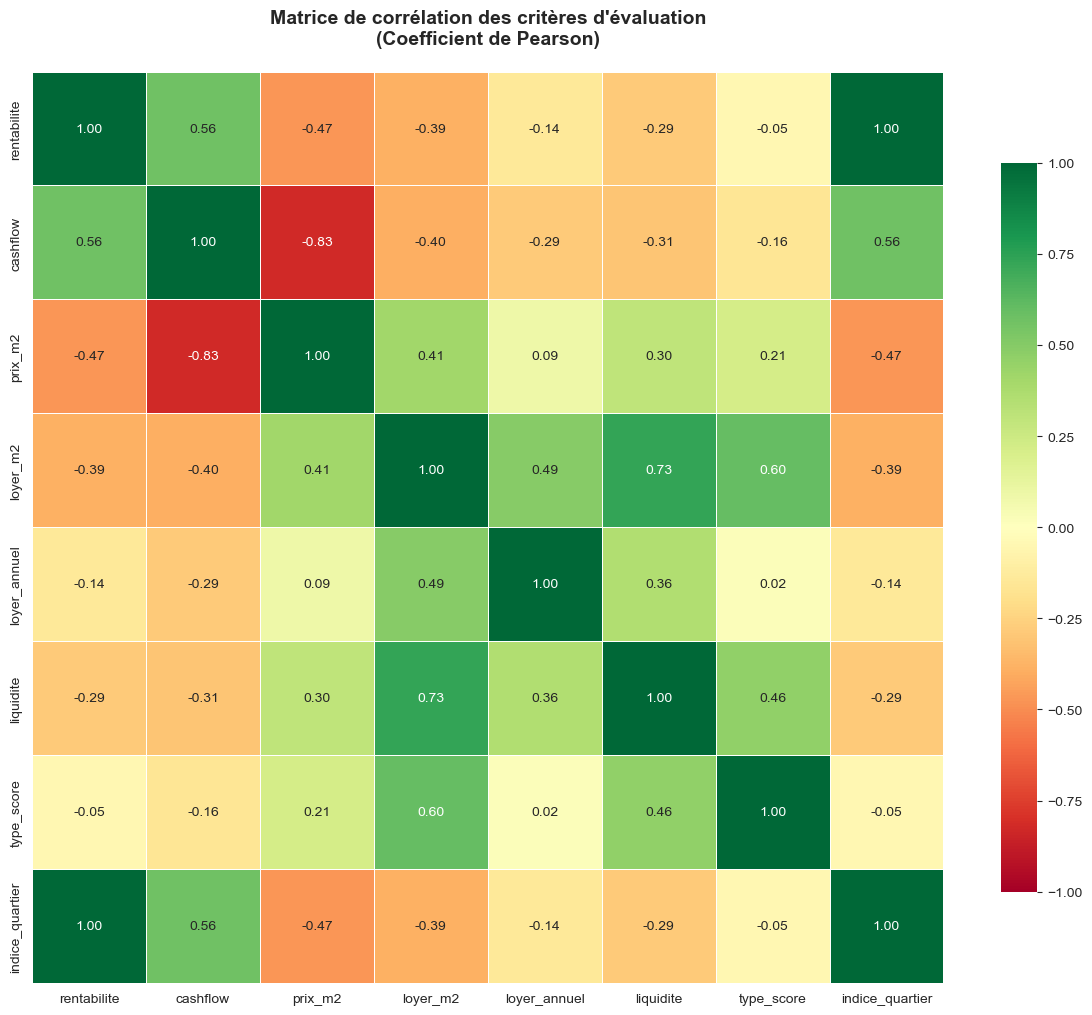

📊 ANALYSE DES CORRÉLATIONS ENTRE CRITÈRES

1️⃣ Validation des colonnes...
  ✓ Toutes les colonnes disponibles (8 critères)

2️⃣ Qualité des données...
  ✓ Pas de valeurs manquantes

3️⃣ Calcul de la matrice de corrélation...
  ✓ Matrice 8×8 calculée (Pearson)

4️⃣ Visualisation de la matrice...


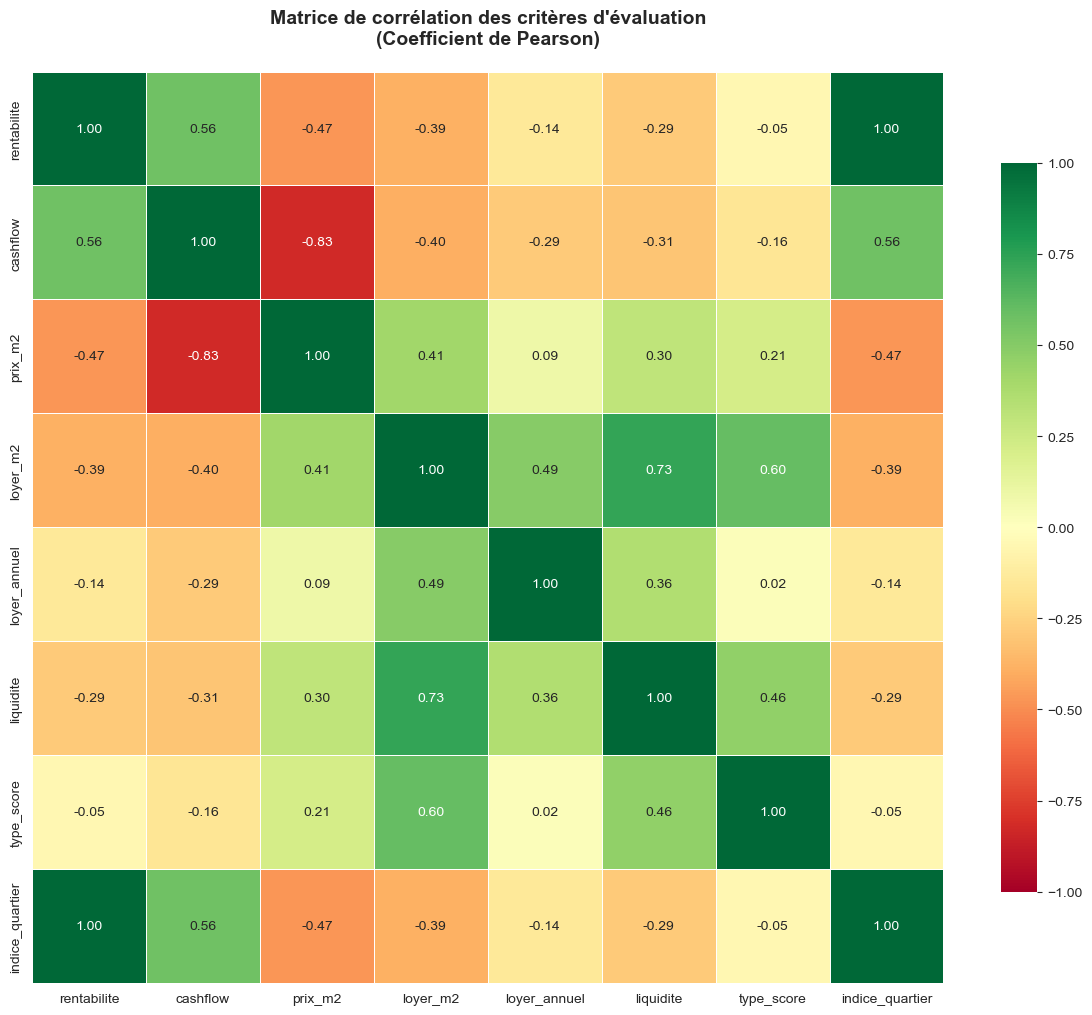


5️⃣ Analyse des corrélations...

  📈 Statistiques des corrélations:
    • Moyenne: 0.041
    • Médiane: -0.048
    • Écart-type: 0.438
    • Min/Max: -0.825 / 1.000

  🔴 Corrélations très fortes (|r| > 0.7):
    • rentabilite          ↔ indice_quartier      :   1.000 (positive)
    • cashflow             ↔ prix_m2              :  -0.825 (négative)
    • loyer_m2             ↔ liquidite            :   0.732 (positive)

  🟡 Corrélations fortes (0.5 < |r| ≤ 0.7):
    • loyer_m2             ↔ type_score           :   0.596 (positive)
    • rentabilite          ↔ cashflow             :   0.565 (positive)
    • cashflow             ↔ indice_quartier      :   0.565 (positive)

  🟠 Corrélations modérées (0.3 < |r| ≤ 0.5):
    • loyer_m2             ↔ loyer_annuel         :   0.493 (positive)
    • prix_m2              ↔ indice_quartier      :  -0.473 (négative)
    • rentabilite          ↔ prix_m2              :  -0.473 (négative)
    • liquidite            ↔ type_score           :   0.461 (p

📊 ANALYSE DES CORRÉLATIONS ENTRE CRITÈRES

1️⃣ Validation des colonnes...
  ✓ Toutes les colonnes disponibles (8 critères)

2️⃣ Qualité des données...
  ✓ Pas de valeurs manquantes

3️⃣ Calcul de la matrice de corrélation...
  ✓ Matrice 8×8 calculée (Pearson)

4️⃣ Visualisation de la matrice...


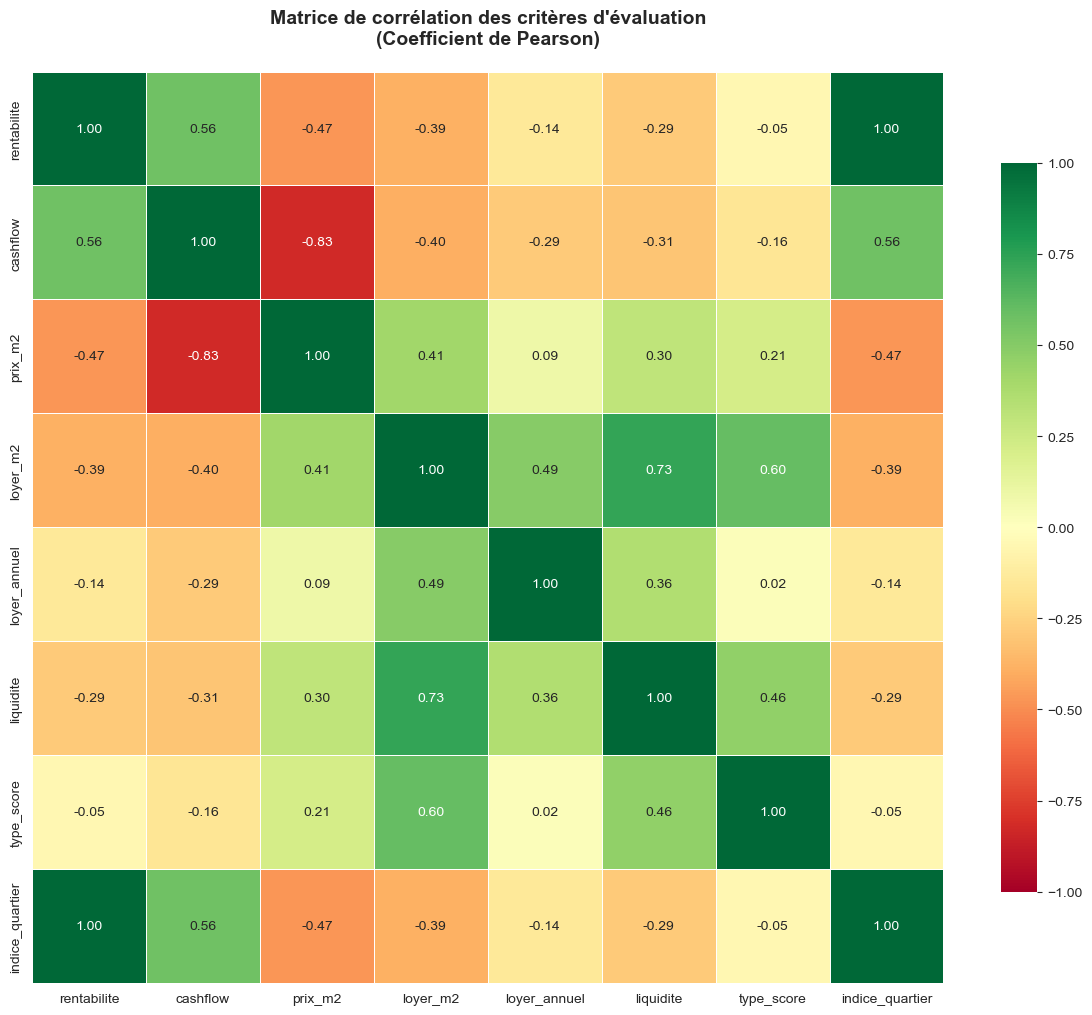


5️⃣ Analyse des corrélations...

  📈 Statistiques des corrélations:
    • Moyenne: 0.041
    • Médiane: -0.048
    • Écart-type: 0.438
    • Min/Max: -0.825 / 1.000

  🔴 Corrélations très fortes (|r| > 0.7):
    • rentabilite          ↔ indice_quartier      :   1.000 (positive)
    • cashflow             ↔ prix_m2              :  -0.825 (négative)
    • loyer_m2             ↔ liquidite            :   0.732 (positive)

  🟡 Corrélations fortes (0.5 < |r| ≤ 0.7):
    • loyer_m2             ↔ type_score           :   0.596 (positive)
    • rentabilite          ↔ cashflow             :   0.565 (positive)
    • cashflow             ↔ indice_quartier      :   0.565 (positive)

  🟠 Corrélations modérées (0.3 < |r| ≤ 0.5):
    • loyer_m2             ↔ loyer_annuel         :   0.493 (positive)
    • prix_m2              ↔ indice_quartier      :  -0.473 (négative)
    • rentabilite          ↔ prix_m2              :  -0.473 (négative)
    • liquidite            ↔ type_score           :   0.461 (p

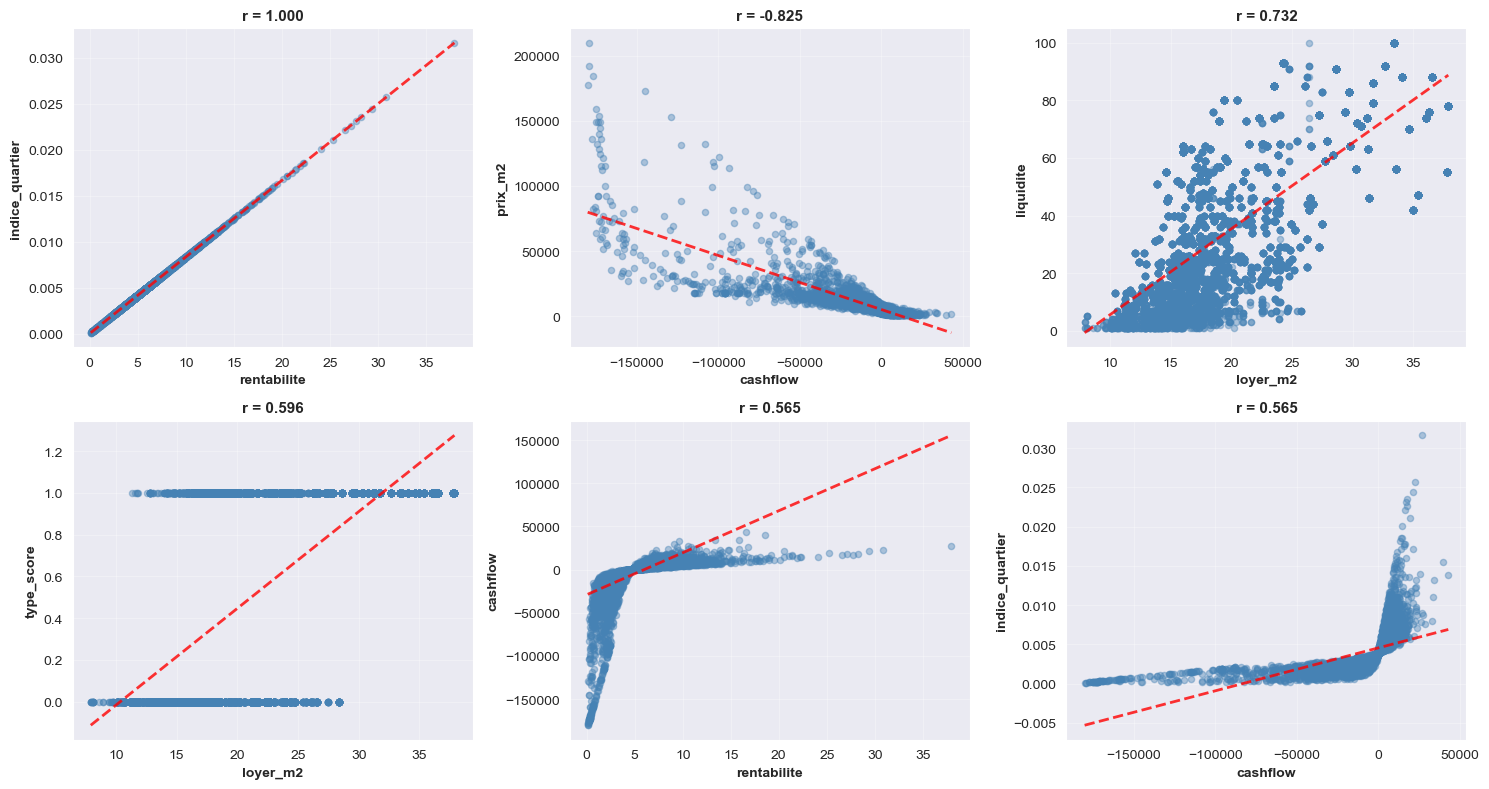


✅ Analyse des corrélations terminée
   • 3 corrélations très fortes (|r| > 0.7)
   • 3 corrélations fortes (0.5 < |r| ≤ 0.7)
   • 11 corrélations modérées (0.3 < |r| ≤ 0.5)



In [53]:
# Cellule 7 - Analyse des corrélations entre critères
print("=" * 70)
print("📊 ANALYSE DES CORRÉLATIONS ENTRE CRITÈRES")
print("=" * 70)

# === COLONNES À ANALYSER ===
crit_cols = [
    "rentabilite",
    "cashflow",
    "prix_m2",
    "loyer_m2",
    "loyer_annuel",
    "liquidite",
    "type_score",
    "indice_quartier",
]

# Valider les colonnes disponibles
print(f"\n1️⃣ Validation des colonnes...")
available_cols = [col for col in crit_cols if col in ac.columns]
missing_cols = [col for col in crit_cols if col not in ac.columns]

if missing_cols:
    print(f"  ⚠️  Colonnes manquantes: {missing_cols}")
    print(f"     Colonnes utilisées: {available_cols}")
    crit_cols = available_cols
else:
    print(f"  ✓ Toutes les colonnes disponibles ({len(crit_cols)} critères)")

# === VÉRIFIER LA QUALITÉ DES DONNÉES ===
print(f"\n2️⃣ Qualité des données...")
missing_rate = ac[crit_cols].isnull().sum() / len(ac) * 100
has_issues = (missing_rate > 0).any()

if has_issues:
    print(f"  ⚠️  Valeurs manquantes détectées:")
    for col in missing_rate[missing_rate > 0].index:
        print(f"    - {col}: {missing_rate[col]:.2f}%")
else:
    print(f"  ✓ Pas de valeurs manquantes")

# === CALCULER LA MATRICE DE CORRÉLATION ===
print(f"\n3️⃣ Calcul de la matrice de corrélation...")
corr_matrix = ac[crit_cols].corr()
print(f"  ✓ Matrice {len(corr_matrix)}×{len(corr_matrix)} calculée (Pearson)")

# === VISUALISATION 1: HEATMAP ===
print(f"\n4️⃣ Visualisation de la matrice...")

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap="RdYlGn",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    vmin=-1,
    vmax=1,
    ax=ax
)
ax.set_title("Matrice de corrélation des critères d'évaluation\n(Coefficient de Pearson)", 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# === ANALYSE QUANTITATIVE ===
print(f"\n5️⃣ Analyse des corrélations...")

# Extraire les corrélations (upper triangle)
correlations = []
for i in range(len(crit_cols)):
    for j in range(i + 1, len(crit_cols)):
        corr_val = corr_matrix.iloc[i, j]
        correlations.append({
            'var1': crit_cols[i],
            'var2': crit_cols[j],
            'correlation': corr_val,
            'abs_corr': abs(corr_val)
        })

# Trier par valeur absolue
correlations_sorted = sorted(correlations, key=lambda x: x['abs_corr'], reverse=True)

# Statistiques globales
print(f"\n  📈 Statistiques des corrélations:")
corr_values = [c['correlation'] for c in correlations]
print(f"    • Moyenne: {np.mean(corr_values):.3f}")
print(f"    • Médiane: {np.median(corr_values):.3f}")
print(f"    • Écart-type: {np.std(corr_values):.3f}")
print(f"    • Min/Max: {min(corr_values):.3f} / {max(corr_values):.3f}")

# Corrélations très fortes (|r| > 0.7)
print(f"\n  🔴 Corrélations très fortes (|r| > 0.7):")
very_strong = [c for c in correlations_sorted if c['abs_corr'] > 0.7]
if very_strong:
    for c in very_strong:
        direction = "positive" if c['correlation'] > 0 else "négative"
        print(f"    • {c['var1']:20} ↔ {c['var2']:20} : {c['correlation']:7.3f} ({direction})")
else:
    print(f"    (aucune corrélation > 0.7)")

# Corrélations fortes (0.5 < |r| ≤ 0.7)
print(f"\n  🟡 Corrélations fortes (0.5 < |r| ≤ 0.7):")
strong = [c for c in correlations_sorted if 0.5 < c['abs_corr'] <= 0.7]
if strong:
    for c in strong:
        direction = "positive" if c['correlation'] > 0 else "négative"
        print(f"    • {c['var1']:20} ↔ {c['var2']:20} : {c['correlation']:7.3f} ({direction})")
else:
    print(f"    (aucune corrélation 0.5-0.7)")

# Corrélations modérées (0.3 < |r| ≤ 0.5)
print(f"\n  🟠 Corrélations modérées (0.3 < |r| ≤ 0.5):")
moderate = [c for c in correlations_sorted if 0.3 < c['abs_corr'] <= 0.5]
if moderate:
    for c in moderate[:5]:  # Afficher les top 5
        direction = "positive" if c['correlation'] > 0 else "négative"
        print(f"    • {c['var1']:20} ↔ {c['var2']:20} : {c['correlation']:7.3f} ({direction})")
    if len(moderate) > 5:
        print(f"    ... et {len(moderate) - 5} autres")
else:
    print(f"    (aucune corrélation 0.3-0.5)")

# === ANALYSE PAR CRITÈRE ===
print(f"\n6️⃣ Analyse par critère (top 3 corrélations):")
for col in crit_cols:
    # Corrélations de ce critère avec les autres
    col_corrs = corr_matrix[col].drop(col).abs().sort_values(ascending=False)
    print(f"\n  {col}:")
    for idx, (other_col, corr_val) in enumerate(col_corrs.head(3).items(), 1):
        actual_corr = corr_matrix.loc[col, other_col]
        direction = "+" if actual_corr > 0 else "−"
        print(f"    {idx}. {other_col:20} : {direction}{corr_val:.3f}")

# === VISUALISATION 2: SCATTER PLOTS DES CORRÉLATIONS FORTES ===
if strong or very_strong:
    print(f"\n7️⃣ Visualisation des corrélations fortes...")
    
    top_pairs = correlations_sorted[:6]  # Top 6 corrélations
    
    n_pairs = len(top_pairs)
    n_cols = 3
    n_rows = (n_pairs + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten() if n_pairs > 1 else [axes]
    
    for idx, pair in enumerate(top_pairs):
        ax = axes[idx]
        x = ac[pair['var1']]
        y = ac[pair['var2']]
        
        # Scatter plot avec regression line
        ax.scatter(x, y, alpha=0.4, s=20, color='steelblue')
        
        # Ajouter une ligne de régression
        z = np.polyfit(x.dropna(), y[x.notna()].dropna(), 1)
        p = np.poly1d(z)
        x_line = np.linspace(x.min(), x.max(), 100)
        ax.plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2)
        
        ax.set_xlabel(pair['var1'], fontsize=10, fontweight='bold')
        ax.set_ylabel(pair['var2'], fontsize=10, fontweight='bold')
        ax.set_title(f"r = {pair['correlation']:.3f}", fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    # Masquer les axes non utilisés
    for idx in range(n_pairs, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"\n  ℹ️  Pas de corrélations fortes pour la visualisation")

# === RÉSUMÉ ===
print(f"\n" + "=" * 70)
print(f"✅ Analyse des corrélations terminée")
print(f"   • {len(very_strong)} corrélations très fortes (|r| > 0.7)")
print(f"   • {len(strong)} corrélations fortes (0.5 < |r| ≤ 0.7)")
print(f"   • {len(moderate)} corrélations modérées (0.3 < |r| ≤ 0.5)")
print("=" * 70 + "\n")

## 8. Filtre de Pareto sur les critères financiers

Avant d’appliquer ELECTRE III, on réduit l’espace de décision en éliminant les actions strictement dominées sur trois critères financiers essentiels : rentabilité, cash‑flow et prix/m².  
On conserve uniquement le front de Pareto, qui représente les compromis non dominés, puis on visualise ce front sur deux graphiques (prix/m² vs rentabilité, cash‑flow vs rentabilité).


🧮 FILTRE DE PARETO — Front non dominé
Nombre d'actions avant déduplication : 11,565
Nombre d'actions après déduplication : 11,565
Filtre de Pareto appliqué:
  • Actions initiales: 11,565
  • Actions du front de Pareto: 25
  • Réduction: 99.8%
  ℹ️  Échantillonnage: 5000 points affichés sur 11,565.


🧮 FILTRE DE PARETO — Front non dominé
Nombre d'actions avant déduplication : 11,565
Nombre d'actions après déduplication : 11,565
Filtre de Pareto appliqué:
  • Actions initiales: 11,565
  • Actions du front de Pareto: 25
  • Réduction: 99.8%
  ℹ️  Échantillonnage: 5000 points affichés sur 11,565.


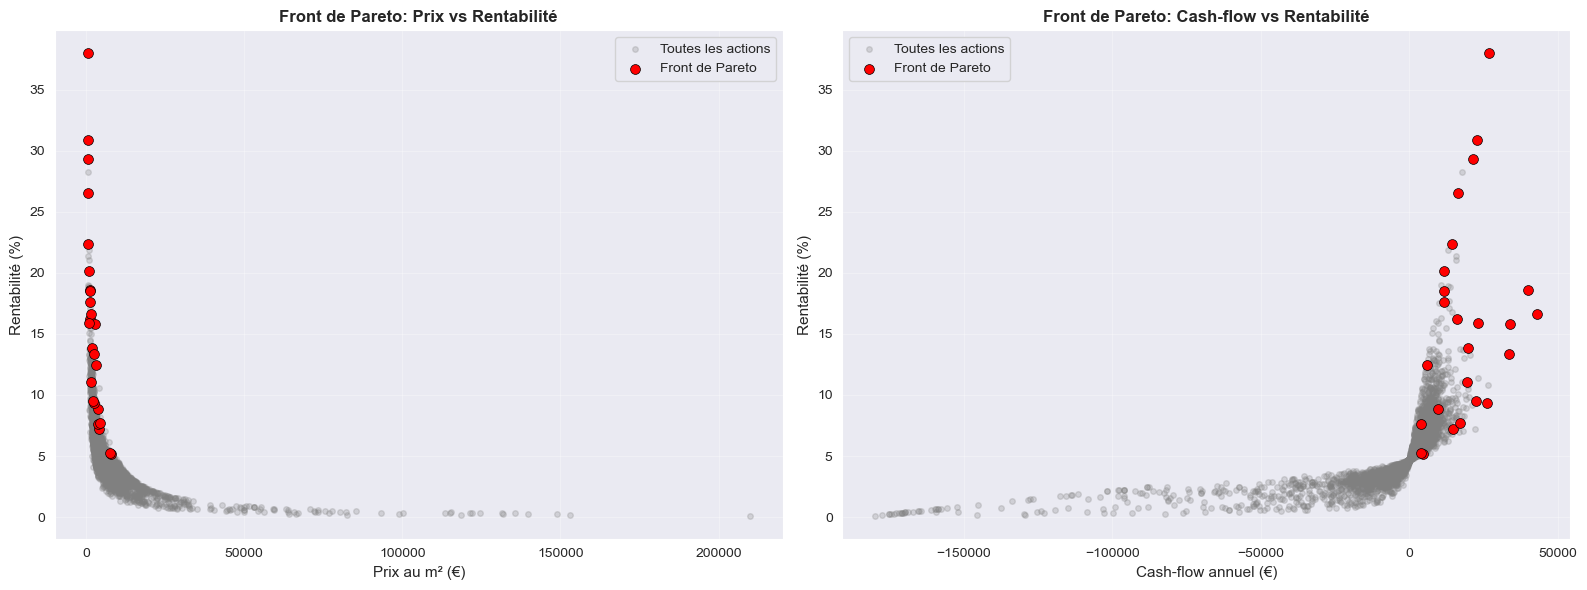

🧮 FILTRE DE PARETO — Front non dominé
Nombre d'actions avant déduplication : 11,565
Nombre d'actions après déduplication : 11,565
Filtre de Pareto appliqué:
  • Actions initiales: 11,565
  • Actions du front de Pareto: 25
  • Réduction: 99.8%
  ℹ️  Échantillonnage: 5000 points affichés sur 11,565.


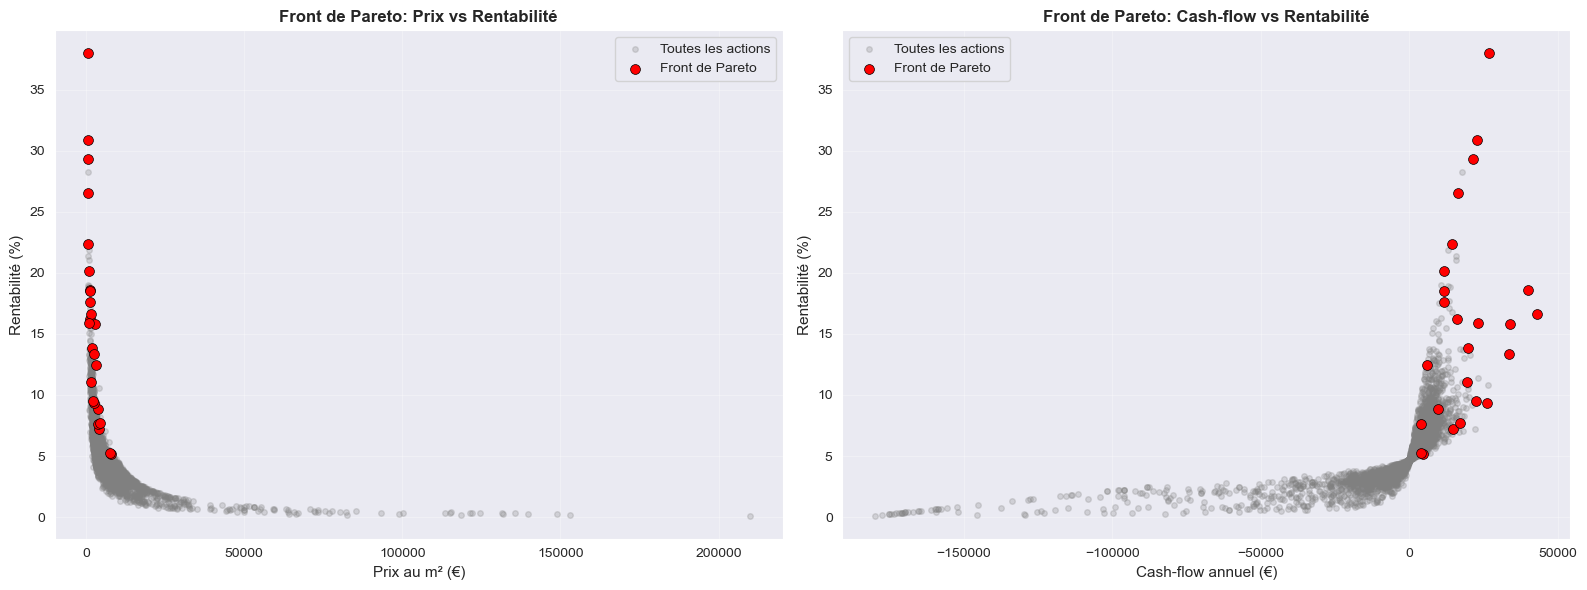


Actions du front de Pareto (aperçu) :

  ✓ Front de Pareto exporté: pareto_front.csv


🧮 FILTRE DE PARETO — Front non dominé
Nombre d'actions avant déduplication : 11,565
Nombre d'actions après déduplication : 11,565
Filtre de Pareto appliqué:
  • Actions initiales: 11,565
  • Actions du front de Pareto: 25
  • Réduction: 99.8%
  ℹ️  Échantillonnage: 5000 points affichés sur 11,565.


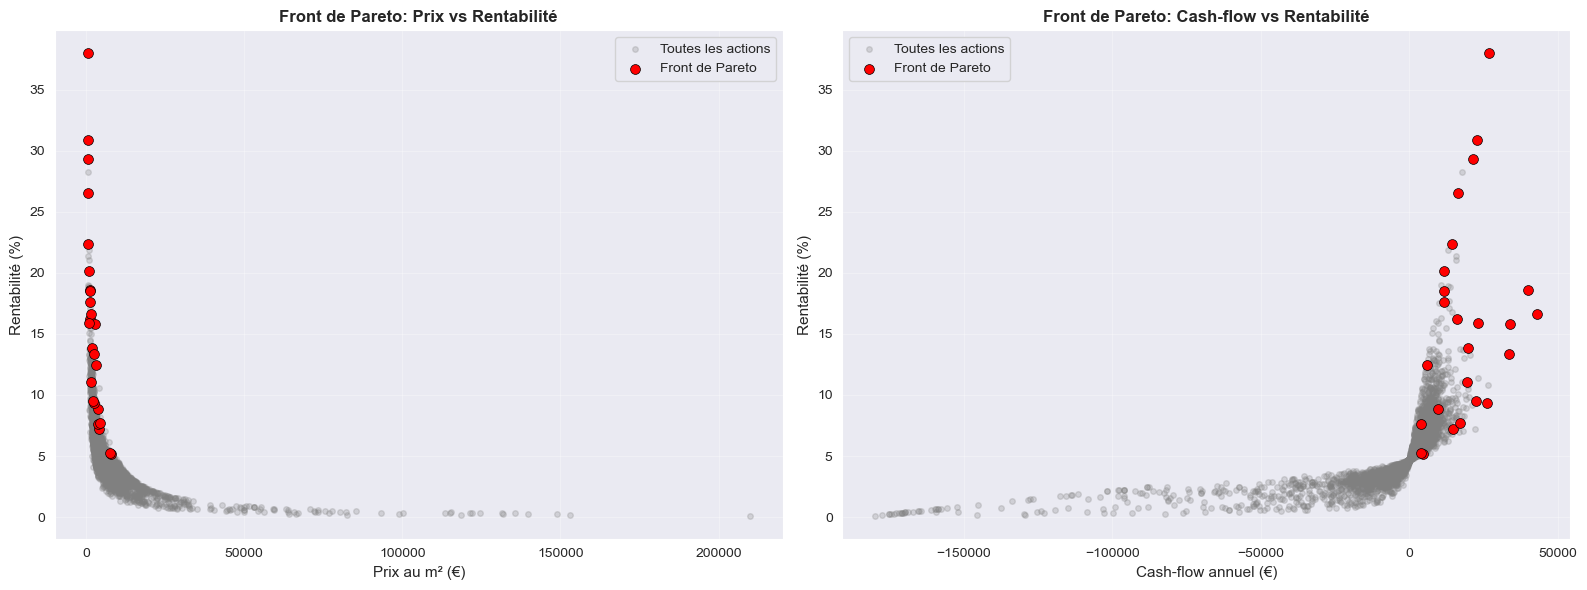


Actions du front de Pareto (aperçu) :

  ✓ Front de Pareto exporté: pareto_front.csv


,action_id,ville,type_local,rentabilite,cashflow,prix_m2,loyer_m2,loyer_annuel,liquidite,type_score,indice_quartier
40300,nan_18/06/2025_77,VILLE-D'AVRAY,Appartement,37.96,26854.26,719.70,22.77,36063.83,18,1,3.16e-02
820,nan_01/04/2025_598,SOISY SS MONTMORENCY,Maison,30.86,22871.79,685.85,17.64,31749.27,37,0,2.57e-02
24251,nan_12/03/2025_674,VILLEPREUX,Maison,29.34,21297.32,788.41,19.28,29841.79,40,0,2.45e-02
25275,nan_12/06/2025_500,PONTOISE,Maison,26.58,16372.37,752.73,16.67,23406.07,46,0,2.21e-02
54287,nan_24/06/2025_504,VILLEMARECHAL,Maison,22.33,14230.97,612.90,11.40,21212.91,4,0,1.86e-02
55086,nan_25/02/2025_607,TAVERNY,Appartement,20.17,11576.39,1074.02,18.05,17763.75,54,1,1.68e-02
2471,nan_02/06/2025_54,ORLY,Maison,18.55,40023.55,1307.69,20.22,63086.53,12,0,1.55e-02
51307,nan_23/06/2025_377,MASSY,Appartement,18.55,11770.88,1298.70,20.08,18553.97,50,1,1.55e-02
17748,nan_09/05/2025_311,HOUILLES,Maison,17.60,11624.11,1293.67,18.97,18667.47,73,0,1.47e-02
45958,nan_21/02/2025_42,JOINVILLE-LE-PONT,Maison,16.60,43028.63,1669.33,23.09,70653.89,25,0,1.38e-02


In [54]:
# Cellule 8 - Filtre de Pareto (front non dominé)
print("=" * 70)
print("🧮 FILTRE DE PARETO — Front non dominé")
print("=" * 70)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Paramètres d'export et de visualisation
EXPORT_PARETO_CSV = True
PARETO_CSV_PATH = "pareto_front.csv"
MAX_VIS_POINTS = 5000  # Limite de points pour les scatter afin d'éviter les lourdeurs


def pareto_filter(df: pd.DataFrame,
                  criteria: list,
                  maximize_dict: dict,
                  dropna: bool = True,
                  return_mask: bool = False):
    """
    Applique un filtre de Pareto pour identifier les actions non dominées.
    Une action A est dominée s'il existe une action B telle que B est >= A
    sur tous les critères (après orientation) et strictement > sur au moins un.

    Args:
        df: DataFrame des actions
        criteria: Liste des critères à considérer (numériques)
        maximize_dict: Dict {critère: True si à maximiser, False si à minimiser}
        dropna: Si True, ignore les lignes avec NaN sur les critères
        return_mask: Si True, retourne aussi le masque booléen du front

    Returns:
        DataFrame contenant uniquement les actions du front de Pareto
        (et éventuellement le masque si return_mask=True)
    """
    # Validations de base
    if df is None or len(df) == 0:
        print("  ⚠️  DataFrame vide — rien à filtrer.")
        return df if not return_mask else (df, np.array([], dtype=bool))

    if not criteria:
        raise ValueError("La liste des critères est vide.")

    missing = [c for c in criteria if c not in df.columns]
    if missing:
        raise KeyError(f"Critères absents dans le DataFrame: {missing}")

    # Orientation des critères: minimiser => multiplier par -1
    maximize_flags = [bool(maximize_dict.get(c, True)) for c in criteria]

    work = df[criteria].copy()
    # Conversion en float (si possible) pour comparaisons robustes
    for c in criteria:
        work[c] = pd.to_numeric(work[c], errors='coerce')

    # Gestion des NaN
    if dropna:
        valid_rows = work.dropna().index
        if len(valid_rows) < len(work):
            dropped = len(work) - len(valid_rows)
            print(f"  ℹ️  {dropped} lignes ignorées (valeurs manquantes sur critères).")
        work = work.loc[valid_rows]
        df_valid = df.loc[valid_rows]
    else:
        df_valid = df

    # Appliquer l'orientation
    oriented = work.to_numpy(dtype=float)
    for k, maximize in enumerate(maximize_flags):
        if not maximize:
            oriented[:, k] *= -1.0

    n = oriented.shape[0]
    if n == 0:
        print("  ⚠️  Aucune ligne valide après nettoyage.")
        pareto_df = df.iloc[[]].copy()
        return pareto_df if not return_mask else (pareto_df, np.array([], dtype=bool))

    # Calcul du front de Pareto (vectorisé par lignes)
    is_efficient = np.ones(n, dtype=bool)
    for i in range(n):
        if not is_efficient[i]:
            continue
        # Comparaisons de toutes les autres lignes à i
        ge_all = (oriented >= oriented[i]).all(axis=1)
        gt_any = (oriented > oriented[i]).any(axis=1)
        dominated_by_any = ge_all & gt_any
        dominated_by_any[i] = False  # ne pas se comparer à soi-même
        if dominated_by_any.any():
            is_efficient[i] = False

    pareto_index = df_valid.index[is_efficient]
    pareto_df = df.loc[pareto_index].copy()

    # Statistiques
    initial_n = len(df)
    pareto_n = len(pareto_df)
    reduction_rate = (1 - pareto_n / initial_n) * 100 if initial_n else 0.0

    print(f"Filtre de Pareto appliqué:")
    print(f"  • Actions initiales: {initial_n:,}")
    print(f"  • Actions du front de Pareto: {pareto_n:,}")
    print(f"  • Réduction: {reduction_rate:.1f}%")

    return pareto_df if not return_mask else (pareto_df, is_efficient)


# Définition des critères et sens d'optimisation pour Pareto
pareto_criteria = ["rentabilite", "cashflow", "prix_m2", "liquidite"]
pareto_maximize = {
    "rentabilite": True,
    "cashflow": True,
    "prix_m2": False,
    "liquidite": True,
}

# Validation préalable de colonnes essentielles
if 'action_id' not in ac.columns:
    raise KeyError("Colonne 'action_id' absente de la table des actions.")

# On garantit des actions uniques pour l'analyse multicritère
# Si des doublons stricts existent sur les critères de Pareto, on les déduplique
dedup_cols = pareto_criteria + ["action_id"]
ac_unique = ac.drop_duplicates(subset=dedup_cols).copy()

print(f"Nombre d'actions avant déduplication : {len(ac):,}")
print(f"Nombre d'actions après déduplication : {len(ac_unique):,}")

# Application du filtre de Pareto
ac_pareto = pareto_filter(ac_unique, pareto_criteria, pareto_maximize, dropna=True)

# Visualisation du front de Pareto (capping des points)
ac_plot = ac
if len(ac_plot) > MAX_VIS_POINTS:
    ac_plot = ac_plot.sample(MAX_VIS_POINTS, random_state=42)
    print(f"  ℹ️  Échantillonnage: {MAX_VIS_POINTS} points affichés sur {len(ac):,}.")

ac_pareto_plot = ac_pareto
if len(ac_pareto_plot) > MAX_VIS_POINTS:
    ac_pareto_plot = ac_pareto_plot.sample(MAX_VIS_POINTS, random_state=42)
    print(f"  ℹ️  Échantillonnage Pareto: {MAX_VIS_POINTS} points affichés sur {len(ac_pareto):,}.")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Prix/m² vs Rentabilité
axes[0].scatter(ac_plot["prix_m2"], ac_plot["rentabilite"], alpha=0.25, s=16, label="Toutes les actions", color='gray')
axes[0].scatter(ac_pareto_plot["prix_m2"], ac_pareto_plot["rentabilite"], s=50, label="Front de Pareto", color='red', edgecolors='black', linewidth=0.5)
axes[0].set_xlabel("Prix au m² (€)", fontsize=11)
axes[0].set_ylabel("Rentabilité (%)", fontsize=11)
axes[0].set_title("Front de Pareto: Prix vs Rentabilité", fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Graphique 2: Cash-flow vs Rentabilité
axes[1].scatter(ac_plot["cashflow"], ac_plot["rentabilite"], alpha=0.25, s=16, label="Toutes les actions", color='gray')
axes[1].scatter(ac_pareto_plot["cashflow"], ac_pareto_plot["rentabilite"], s=50, label="Front de Pareto", color='red', edgecolors='black', linewidth=0.5)
axes[1].set_xlabel("Cash-flow annuel (€)", fontsize=11)
axes[1].set_ylabel("Rentabilité (%)", fontsize=11)
axes[1].set_title("Front de Pareto: Cash-flow vs Rentabilité", fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# === Affichage du front de Pareto ===
print("\nActions du front de Pareto (aperçu) :\n")

# Tri optionnel par rentabilité décroissante puis prix_m2 croissant
ac_pareto_display = ac_pareto.sort_values(
    by=["rentabilite", "cashflow", "prix_m2"],
    ascending=[False, False, True]
)

# Colonnes principales à afficher
cols = [
    "action_id",
    "ville",
    "type_local",
    "rentabilite",
    "cashflow",
    "prix_m2",
    "loyer_m2",
    "loyer_annuel",
    "liquidite",
    "type_score",
    "indice_quartier",
]

# Si action_id est l'index, on le remet en colonne
if "action_id" not in ac_pareto_display.columns and ac_pareto_display.index.name == "action_id":
    ac_pareto_display = ac_pareto_display.reset_index()

# Déduplication finale par action_id
ac_pareto_display = ac_pareto_display.drop_duplicates(subset=["action_id"]).copy()

# Export CSV (optionnel)
if EXPORT_PARETO_CSV:
    try:
        ac_pareto_display.to_csv(PARETO_CSV_PATH, index=False)
        print(f"  ✓ Front de Pareto exporté: {PARETO_CSV_PATH}")
    except Exception as e:
        print(f"  ⚠️  Échec export CSV: {e}")

# Affichage
ac_pareto_display[cols]

## 9. Mise en œuvre de la méthode ELECTRE III

Cette partie met en place la méthode ELECTRE III :  
- définition des critères considérés, sens d’optimisation et poids ;  
- normalisation des performances (min–max) ;  
- calcul des pseudo‑critères (seuils d’indifférence q, de préférence p, et de veto v) à partir de la dispersion observée ;  
- construction de la matrice de crédibilité σ(a,b) ;  
- calcul des scores de net flow φ(a) pour obtenir un classement des actions ;  
- recherche d’un noyau strict et d’un noyau “dynamique” basé sur le seuil σ_max.  

On obtient ainsi un pré‑ordre des actions reflétant la logique de surclassement non compensatoire.


In [27]:
# Cellule 20 – ELECTRE III : matrice de crédibilité σ(a,b)
print("=" * 70)
print("ELECTRE III — Matrice de crédibilité σ(a,b)")
print("=" * 70)

def electre3_sigma(
    perf: pd.DataFrame,
    criteria: list,
    maximize: dict,
    weights: dict,
    thresholds: dict,
) -> pd.DataFrame:
    """
    Calcule la matrice de crédibilité σ(a,b) de la méthode ELECTRE III
    pour un ensemble d'actions immobilières.

    Chaque critère j est traité comme un pseudo‑critère muni de seuils
    d'indifférence q_j, de préférence p_j et de veto v_j, définis sur
    les performances déjà normalisées dans [0,1].

    Paramètres
    ----------
    perf : DataFrame
        Matrice actions × critères (index = action_id).
        Doit contenir au moins les 8 critères du projet :
        rentabilite, cashflow, prix_m2, loyer_m2, loyer_annuel,
        liquidite, type_score, indice_quartier.

    criteria : list[str]
        Liste ordonnée des critères à utiliser.

    maximize : dict[str, bool]
        True si le critère est à maximiser, False si à minimiser.

    weights : dict[str, float]
        Poids w_j ≥ 0 de chaque critère, en cohérence avec ta hiérarchie :
        - niveau 1 (forts poids) : rentabilite, cashflow, liquidite
        - niveau 2 : prix_m2, loyer_m2, indice_quartier
        - niveau 3 : type_score, loyer_annuel.

    thresholds : dict[str, dict]
        Pour chaque critère j :
            thresholds[j] = {"q": q_j, "p": p_j, "v": v_j}
        avec 0 ≤ q_j ≤ p_j ≤ v_j sur l'échelle normalisée.

    Retour
    ------
    DataFrame (n×n)
        Matrice de crédibilité σ(a,b), index/colonnes = action_id.
    """

    # === VALIDATIONS GLOBALES ===
    if perf is None or len(perf) == 0:
        raise ValueError("perf est vide")
    if not criteria:
        raise ValueError("La liste des critères est vide")

    missing_cols = [c for c in criteria if c not in perf.columns]
    if missing_cols:
        raise KeyError(f"Colonnes absentes dans perf: {missing_cols}")

    for c in criteria:
        if c not in maximize:
            raise KeyError(f"Sens d'optimisation manquant pour '{c}'")
        if c not in weights:
            raise KeyError(f"Poids manquant pour '{c}'")
        if c not in thresholds or not all(k in thresholds[c] for k in ("q", "p", "v")):
            raise KeyError(f"Seuils q,p,v manquants pour '{c}'")

    # Vérification des seuils et poids
    for c in criteria:
        q, p, v = thresholds[c]["q"], thresholds[c]["p"], thresholds[c]["v"]
        if any(t < 0 for t in (q, p, v)):
            raise ValueError(f"Seuils négatifs pour '{c}': q={q}, p={p}, v={v}")
        if not (q <= p <= v):
            raise ValueError(f"Ordre des seuils invalide pour '{c}': il faut q <= p <= v")
        if weights[c] < 0:
            raise ValueError(f"Poids négatif pour '{c}': {weights[c]}")

    ids = perf.index.to_list()
    n = len(ids)
    m = len(criteria)

    # === MATRICE DES PERFORMANCES (m × n) ===
    X = np.vstack(
        [pd.to_numeric(perf[c], errors="coerce").to_numpy(dtype=float) for c in criteria]
    )

    # Remplacer les NaN par la moyenne du critère (stabilisation simple)
    for k in range(m):
        col = X[k]
        if np.isnan(col).any():
            mean_val = np.nanmean(col)
            X[k] = np.where(np.isnan(col), mean_val, col)

    # Vecteurs de paramètres
    W = np.array([weights[c] for c in criteria], dtype=float)
    W_sum = W.sum()
    if W_sum <= 0:
        raise ValueError("Somme des poids nulle ou négative")

    # +1 si on maximise, -1 si on minimise
    maximize_flags = np.array(
        [1.0 if maximize[c] else -1.0 for c in criteria], dtype=float
    )

    q_vec = np.array([thresholds[c]["q"] for c in criteria], dtype=float)
    p_vec = np.array([thresholds[c]["p"] for c in criteria], dtype=float)
    v_vec = np.array([thresholds[c]["v"] for c in criteria], dtype=float)

    sigma = np.zeros((n, n), dtype=float)

    print(f"Calcul de la matrice ELECTRE III sur {n} actions et {m} critères...")

    # === BOUCLE SUR LES PAIRES (a,b) ===
    for ia in range(n):
        for ib in range(n):
            if ia == ib:
                sigma[ia, ib] = 1.0
                continue

            # Différences orientées : delta_j = sign * (g_j(a) - g_j(b))
            delta = maximize_flags * (X[:, ia] - X[:, ib])

            # ----- Concordance partielle c_j(a,b) -----
            c_part = np.empty(m, dtype=float)

            # Cas 1 : delta >= -q  -> plein accord
            mask_full = delta >= (-q_vec)
            # Cas 2 : delta <= -p  -> aucun accord
            mask_none = delta <= (-p_vec)
            # Cas 3 : zone intermédiaire
            mask_lin = ~(mask_full | mask_none)

            c_part[mask_full] = 1.0
            c_part[mask_none] = 0.0

            denom = (p_vec - q_vec)
            denom_safe = np.where(denom == 0, 1e-12, denom)
            c_part[mask_lin] = (delta[mask_lin] + p_vec[mask_lin]) / denom_safe[mask_lin]
            c_part = np.clip(c_part, 0.0, 1.0)

            # Concordance globale pondérée C(a,b)
            C = float(np.dot(W, c_part) / W_sum)

            # ----- Discordance d_j(a,b) + veto -----
            d_part = np.empty(m, dtype=float)

            # Cas 1 : delta >= -p  -> pas de discordance
            mask_d0 = delta >= (-p_vec)
            # Cas 2 : delta <= -v  -> veto
            mask_veto = delta <= (-v_vec)
            # Cas 3 : discordance partielle
            mask_dlin = ~(mask_d0 | mask_veto)

            d_part[mask_d0] = 0.0
            d_part[mask_veto] = 1.0

            denom_d = (v_vec - p_vec)
            denom_d_safe = np.where(denom_d == 0, 1e-12, denom_d)
            d_part[mask_dlin] = (-delta[mask_dlin] - p_vec[mask_dlin]) / denom_d_safe[mask_dlin]
            d_part = np.clip(d_part, 0.0, 1.0)

            # Test de veto : si un critère est en veto, σ(a,b) = 0
            if mask_veto.any():
                sigma[ia, ib] = 0.0
                continue

            # ----- Crédibilité σ(a,b) -----
            s = C
            # Réduction de C si certains d_j > C (discordance forte)
            over_mask = d_part > C
            if over_mask.any():
                s *= np.prod((1.0 - d_part[over_mask]) / (1.0 - C))

            sigma[ia, ib] = float(np.clip(s, 0.0, 1.0))

    print("✓ Matrice de crédibilité σ calculée")
    print(f"  • Moyenne σ: {sigma.mean():.3f}")
    print(f"  • Médiane σ: {np.median(sigma):.3f}")

    return pd.DataFrame(sigma, index=ids, columns=ids)


ELECTRE III — Matrice de crédibilité σ(a,b)


In [28]:
# On force la source ELECTRE sur le front de Pareto
ac_work = ac_pareto.copy()
print(f"ac_work défini à partir du front de Pareto : {len(ac_work)} actions")


ac_work défini à partir du front de Pareto : 25 actions


In [29]:
# Cellule 21 – ELECTRE III : net flows et noyau
print("=" * 70)
print("ELECTRE III — Classement net flow et noyau")
print("=" * 70)

import numpy as np
import pandas as pd


def netflow_ranking(sigma: pd.DataFrame) -> pd.DataFrame:
    """
    Calcule le score de net flow φ(a) = φ⁺(a) − φ⁻(a) pour chaque action.

    φ⁺(a) = somme des crédibilités σ(a,b) (a surclasse b),
    φ⁻(a) = somme des crédibilités σ(b,a) (b surclasse a),
    en ignorant la diagonale.

    Paramètres
    ----------
    sigma : DataFrame (n×n)
        Matrice de crédibilité σ(a,b), index/colonnes = action_id.

    Retour
    ------
    DataFrame
        Colonne 'phi_netflow', triée par ordre décroissant.
    """
    if not isinstance(sigma, pd.DataFrame):
        raise TypeError("sigma doit être un DataFrame")
    if sigma.shape[0] != sigma.shape[1]:
        raise ValueError("sigma doit être carré")

    ids = sigma.index
    M = sigma.values.astype(float)

    # Sommes ligne/colonne hors diagonale
    diag = np.diag(M)
    outflow = M.sum(axis=1) - diag   # φ⁺
    inflow = M.sum(axis=0) - diag    # φ⁻

    phi = outflow - inflow

    s = pd.Series(phi, index=ids, name="phi_netflow")

    print("\nDistribution des scores net flow φ(a) :")
    print(f"  • Maximum : {s.max():.3f}")
    print(f"  • Q3      : {s.quantile(0.75):.3f}")
    print(f"  • Médiane : {s.median():.3f}")
    print(f"  • Q1      : {s.quantile(0.25):.3f}")
    print(f"  • Minimum : {s.min():.3f}")

    return s.sort_values(ascending=False).to_frame()


def electre_kernel(sigma: pd.DataFrame, lambda_cut: float = 0.6) -> list:
    """
    Identifie le noyau ELECTRE : actions non surclassées de manière forte.

    Règle de domination :
        b domine a si σ(b,a) ≥ λ et σ(a,b) < λ.

    Dans le noyau, aucune autre action ne domine strictement l'action considérée,
    au seuil de crédibilité λ. C'est l'ensemble des "candidats robustes"
    au sens de ton projet immobilier.

    Paramètres
    ----------
    sigma : DataFrame (n×n)
        Matrice de crédibilité σ(a,b).

    lambda_cut : float
        Seuil de crédibilité λ dans [0,1].
        Valeurs typiques : 0.6–0.8 pour un surclassement exigeant.

    Retour
    ------
    list
        Liste des identifiants d'actions appartenant au noyau.
    """
    if not isinstance(sigma, pd.DataFrame):
        raise TypeError("sigma doit être un DataFrame")
    if sigma.shape[0] != sigma.shape[1]:
        raise ValueError("sigma doit être carré")
    if not (0.0 <= lambda_cut <= 1.0):
        raise ValueError("lambda_cut doit être dans [0,1]")

    ids = sigma.index.to_list()
    M = sigma.values.astype(float)

    # Matrice de surclassement fort (σ >= λ)
    surclasse = (M >= lambda_cut)
    reciproque_forte = (M.T >= lambda_cut)

    # b domine a si b→a fort et pas a→b fort
    domination = surclasse & (~reciproque_forte)

    # Ignorer la diagonale
    np.fill_diagonal(domination, False)

    # a est dominée si ∃ b tel que b domine a (colonne vraie)
    dominated = domination.any(axis=0)
    kernel_mask = ~dominated

    kernel_ids = [ids[i] for i, keep in enumerate(kernel_mask) if keep]

    print(f"\nNoyau ELECTRE (λ = {lambda_cut:.2f}) :")
    print(f"  • {len(kernel_ids)} actions dans le noyau")
    print(f"  • {len(kernel_ids)/len(ids)*100:.1f}% de l'ensemble")

    return kernel_ids


ELECTRE III — Classement net flow et noyau


In [30]:
# Cellule 21bis – Préparation des entrées ELECTRE (perf_norm, critères, poids, seuils)
print("=" * 70)
print("Préparation des variables ELECTRE (perf_norm, critères, poids, seuils)")
print("=" * 70)

import numpy as np
import pandas as pd

# 1) Source de données : ac_work prioritaire, sinon ac
if "ac_work" in locals() and isinstance(ac_work, pd.DataFrame) and not ac_work.empty:
    src = ac_work.copy()
    print("  ✓ Source : ac_work")
elif "ac" in locals() and isinstance(ac, pd.DataFrame) and not ac.empty:
    src = ac.copy()
    print("  ✓ Source : ac (fallback)")
else:
    raise NameError("Aucune table d'actions disponible (ni ac_work ni ac)")

# S’assurer de la colonne action_id
if "action_id" not in src.columns:
    src = src.reset_index()
    if "action_id" not in src.columns and "index" in src.columns:
        src = src.rename(columns={"index": "action_id"})
        print("  ℹ️ 'action_id' recréé depuis l'index")
if "action_id" not in src.columns:
    raise KeyError("La table source ne contient pas 'action_id'.")

# 2) Critères ELECTRE du projet (8 critères)
electre_criteria = [
    "rentabilite",
    "cashflow",
    "prix_m2",
    "loyer_m2",
    "loyer_annuel",
    "liquidite",
    "type_score",
    "indice_quartier",
]

# Garder seulement ceux qui existent réellement
electre_criteria = [c for c in electre_criteria if c in src.columns]
if not electre_criteria:
    raise ValueError("Aucun des critères ELECTRE attendus n'est présent dans la table.")

work = src[["action_id"] + electre_criteria].copy()
for c in electre_criteria:
    work[c] = pd.to_numeric(work[c], errors="coerce")

# Supprimer les actions sans aucune valeur sur les critères
valid_mask = work[electre_criteria].notna().any(axis=1)
work = work.loc[valid_mask]
dropped = (~valid_mask).sum()
if dropped:
    print(f"  ℹ️ {dropped} lignes supprimées (toutes valeurs NaN sur critères)")

# 3) Normalisation min–max critère par critère
perf_raw = work.set_index("action_id")[electre_criteria]

mins = perf_raw.min(axis=0)
maxs = perf_raw.max(axis=0)
ranges = (maxs - mins).replace(0, np.nan)

perf_norm = (perf_raw - mins) / ranges

# Retirer les critères constants (range = 0)
const_cols = perf_norm.columns[perf_norm.isna().all()].tolist()
if const_cols:
    print(f"  ℹ️ Critères constants retirés : {const_cols}")
    perf_norm = perf_norm.drop(columns=const_cols)
    electre_criteria = [c for c in electre_criteria if c not in const_cols]

perf_norm = perf_norm.fillna(0.0)

# 4) Sens d'optimisation, poids et seuils, alignés avec la hiérarchie du projet

# Sens d'optimisation : tout à maximiser sauf prix_m2
electre_maximize = {c: True for c in electre_criteria}
if "prix_m2" in electre_maximize:
    electre_maximize["prix_m2"] = False

# Poids hiérarchiques (Niveau 1 > 2 > 3)
weights = {c: 1.0 for c in electre_criteria}

for c in ["rentabilite", "cashflow", "liquidite"]:
    if c in weights:
        weights[c] = 3.0   # niveau 1 (critique)

for c in ["prix_m2", "loyer_m2", "indice_quartier"]:
    if c in weights:
        weights[c] = 2.0   # niveau 2 (important)

for c in ["type_score", "loyer_annuel"]:
    if c in weights:
        weights[c] = 1.0   # niveau 3 (secondaire)

# Seuils par défaut sur l'échelle normalisée [0,1]
# Indifférence q ~ 5%, préférence p ~ 15%, veto v ~ 30%
thresholds = {}
for c in electre_criteria:
    thresholds[c] = {"q": 0.05, "p": 0.15, "v": 0.30}

print("\nRésumé préparation :")
print(f"  • Actions : {len(perf_norm):,}")
print(f"  • Critères ELECTRE : {len(electre_criteria)} — {electre_criteria}")

# 5) Calcul automatique de σ si possible
if "electre3_sigma" in globals():
    try:
        sigma = electre3_sigma(perf_norm, electre_criteria, electre_maximize, weights, thresholds)
        print("\n  ✓ Matrice σ calculée automatiquement")
    except Exception as e:
        print(f"\n  ⚠️ Échec du calcul automatique de σ : {e}")
else:
    print("\n  ⚠️ Fonction electre3_sigma non disponible dans l'environnement courant")


Préparation des variables ELECTRE (perf_norm, critères, poids, seuils)
  ✓ Source : ac_work

Résumé préparation :
  • Actions : 25
  • Critères ELECTRE : 8 — ['rentabilite', 'cashflow', 'prix_m2', 'loyer_m2', 'loyer_annuel', 'liquidite', 'type_score', 'indice_quartier']
Calcul de la matrice ELECTRE III sur 25 actions et 8 critères...
✓ Matrice de crédibilité σ calculée
  • Moyenne σ: 0.188
  • Médiane σ: 0.000

  ✓ Matrice σ calculée automatiquement


In [31]:
# Cellule 22 - Extraction du noyau ELECTRE (λ fixe et dynamique)
print("=" * 70)
print("🧩 ELECTRE III — Noyau (λ fixe et λ dynamique)")
print("=" * 70)

import numpy as np
import pandas as pd

# === Préparation: s'assurer que sigma et ac_work existent ===
proceed = True

# 1) Assurer sigma: si absent, tenter de le calculer
if 'sigma' not in locals() or sigma is None:
    print("ℹ️ 'sigma' absent — tentative de calcul via electre3_sigma...")
    prereq = ['perf_norm', 'electre_criteria', 'electre_maximize', 'weights', 'thresholds']
    missing_prereq = [v for v in prereq if v not in locals()]
    if missing_prereq:
        print(f"  ⚠️ Impossible de calculer σ: variables manquantes {missing_prereq}")
        proceed = False
    elif 'electre3_sigma' not in globals():
        print("  ⚠️ Fonction 'electre3_sigma' indisponible — exécutez la cellule de définition d'abord.")
        proceed = False
    else:
        try:
            sigma = electre3_sigma(perf_norm, electre_criteria, electre_maximize, weights, thresholds)
            print("  ✓ σ calculé avec succès.")
        except Exception as e:
            print(f"  ❌ Échec du calcul de σ: {e}")
            proceed = False

# 2) Assurer ac_work: si absent, tenter un fallback depuis ac
if 'ac_work' not in locals() or ac_work is None:
    if 'ac' in locals() and isinstance(ac, pd.DataFrame) and len(ac) > 0:
        ac_work = ac.copy()
        print("ℹ️ 'ac_work' absent — fallback sur 'ac'.")
    else:
        print("⚠️ Données 'ac_work' et 'ac' indisponibles — les caractéristiques détaillées seront omises.")
        ac_work = pd.DataFrame()

# 3) S'assurer que la colonne action_id existe si possible
if isinstance(ac_work, pd.DataFrame) and not ac_work.empty and 'action_id' not in ac_work.columns:
    if ac_work.index.name == 'action_id':
        ac_work = ac_work.reset_index()
        print("  ✓ 'action_id' restauré depuis l'index.")
    else:
        ac_work = ac_work.reset_index()
        if 'index' in ac_work.columns:
            ac_work.rename(columns={'index': 'action_id'}, inplace=True)
            print("  ✓ 'action_id' recréé depuis l'index (nommé 'index').")

# Si on ne peut pas poursuivre, sortir proprement
if not proceed:
    print("Arrêt: préparez les variables requises et relancez cette cellule.")
else:
    # Validation de la matrice sigma
    if not isinstance(sigma, pd.DataFrame):
        raise TypeError("sigma doit être un DataFrame carré")
    if sigma.shape[0] != sigma.shape[1]:
        raise ValueError("sigma doit être carré")

    ids = sigma.index.to_list()
    n = len(ids)

    # 1) Noyau classique pour λ = 0.6 (avec ajustement si vide)
    lambda_initial = 0.6
    lambda_cut = lambda_initial
    noyau_ids = electre_kernel(sigma, lambda_cut=lambda_cut)

    if len(noyau_ids) == 0:
        print(f"\nNoyau vide avec λ={lambda_cut}. Ajustement du seuil...")
        for lambda_try in [0.55, 0.5, 0.45, 0.4, 0.35, 0.3]:
            noyau_ids = electre_kernel(sigma, lambda_cut=lambda_try)
            if len(noyau_ids) > 0:
                lambda_cut = lambda_try
                print(f"Seuil ajusté: λ={lambda_cut} → {len(noyau_ids)} actions dans le noyau")
                break
        if len(noyau_ids) == 0:
            print("Aucun noyau pour les λ fixes testés (jusqu'à 0.3).")

    # Construire le DataFrame noyau si possible
    if len(noyau_ids) > 0:
        if ac_work is None or ac_work.empty:
            print("⚠️ Données 'ac_work' indisponibles — impossible d'afficher les caractéristiques.")
            noyau = pd.DataFrame(index=noyau_ids).reset_index().rename(columns={'index': 'action_id'})
        else:
            if 'action_id' not in ac_work.columns:
                raise KeyError("'ac_work' doit contenir la colonne 'action_id'.")
            # Harmoniser type
            ids_str = pd.Index(noyau_ids).astype(str)
            ac_work_ids = ac_work['action_id'].astype(str)
            select_ids = [aid for aid in ids_str if aid in ac_work_ids.values]
            noyau = ac_work.assign(_aid=ac_work_ids).set_index('_aid').loc[select_ids].reset_index().rename(columns={'_aid':'action_id'})
            # déduplication par action_id pour le noyau
            noyau = noyau.drop_duplicates(subset=["action_id"]).copy()
    else:
        noyau = pd.DataFrame()

    # 2) Noyau dynamique basé sur σ_max (hors diagonale)
    sigma_no_diag = sigma.copy()
    arr = sigma_no_diag.values
    np.fill_diagonal(arr, np.nan)
    try:
        sigma_max = float(np.nanmax(arr))
    except ValueError:
        # Si tout est NaN (cas pathologique), fallback sur quantile 95% de sigma hors diagonale
        flat = arr.flatten()
        flat = flat[~np.isnan(flat)]
        sigma_max = float(np.quantile(flat, 0.95)) if flat.size else 0.0

    lambda_dyn = sigma_max
    noyau_ids_dyn = electre_kernel(sigma, lambda_cut=lambda_dyn)

    print(f"\nSeuil dynamique pour le noyau: λ = σ_max = {lambda_dyn:.3f}")
    print(f"  • Taille du noyau dynamique: {len(noyau_ids_dyn)} actions")

    # Statistiques du noyau "classique"
    if len(noyau) > 0:
        # Colonnes nécessaires
        cols_needed = ["rentabilite", "cashflow", "prix_m2", "ville", "type_local", "loyer_m2", "loyer_annuel", "liquidite", "type_score", "indice_quartier"]
        missing_cols = [c for c in cols_needed if c not in noyau.columns]
        if missing_cols:
            print(f"⚠️ Colonnes manquantes pour l'analyse du noyau: {missing_cols}")

        print(f"\nCaractéristiques du noyau (λ={lambda_cut}):")
        if "rentabilite" in noyau.columns:
            print(f"  • Rentabilité moyenne: {noyau['rentabilite'].mean():.2f}%")
        if "cashflow" in noyau.columns:
            print(f"  • Cash-flow moyen:     {noyau['cashflow'].mean():.0f} €")
        if "prix_m2" in noyau.columns:
            print(f"  • Prix/m² moyen:       {noyau['prix_m2'].mean():.0f} €")

        if "ville" in noyau.columns:
            print(f"\nTop 5 villes représentées (noyau λ fixe):")
            print(noyau['ville'].value_counts().head().to_string())

        display_cols = [
            "action_id", "ville", "type_local", "rentabilite", "cashflow", "prix_m2",
            "loyer_m2", "loyer_annuel", "liquidite", "type_score", "indice_quartier"
        ]
        print(f"\nMeilleures actions du noyau (λ fixe):")
        cols_present = [c for c in display_cols if c in noyau.columns]
        if cols_present:
            print(noyau.sort_values("rentabilite", ascending=False)[cols_present].head(10).to_string(index=False))
        else:
            print("Colonnes d'affichage indisponibles pour le noyau.")
    else:
        print("\nNoyau vide pour tous les λ fixes testés.")

    # Aperçu du noyau dynamique
    if len(noyau_ids_dyn) > 0 and isinstance(ac_work, pd.DataFrame) and not ac_work.empty and 'action_id' in ac_work.columns:
        ac_work_ids = ac_work['action_id'].astype(str)
        select_ids_dyn = [aid for aid in pd.Index(noyau_ids_dyn).astype(str) if aid in ac_work_ids.values]
        noyau_dyn = ac_work.assign(_aid=ac_work_ids).set_index('_aid').loc[select_ids_dyn].reset_index().rename(columns={'_aid':'action_id'})
        noyau_dyn = noyau_dyn.drop_duplicates(subset=["action_id"]).copy()
        print(f"\nExemple d'actions du noyau dynamique (λ = σ_max):")
        display_cols = [
            "action_id", "ville", "type_local", "rentabilite", "cashflow", "prix_m2",
            "loyer_m2", "loyer_annuel", "liquidite", "type_score", "indice_quartier"
        ]
        cols_present_dyn = [c for c in display_cols if c in noyau_dyn.columns]
        if cols_present_dyn:
            print(noyau_dyn.sort_values("rentabilite", ascending=False)[cols_present_dyn].head(10).to_string(index=False))
        else:
            print("Colonnes d'affichage indisponibles pour le noyau dynamique.")
    else:
        print("Aucun noyau même avec λ = σ_max ou données manquantes.")

🧩 ELECTRE III — Noyau (λ fixe et λ dynamique)

Noyau ELECTRE (λ = 0.60) :
  • 3 actions dans le noyau
  • 12.0% de l'ensemble

Noyau ELECTRE (λ = 1.00) :
  • 16 actions dans le noyau
  • 64.0% de l'ensemble

Seuil dynamique pour le noyau: λ = σ_max = 1.000
  • Taille du noyau dynamique: 16 actions

Caractéristiques du noyau (λ=0.6):
  • Rentabilité moyenne: 24.12%
  • Cash-flow moyen:     33643 €
  • Prix/m² moyen:       1599 €

Top 5 villes représentées (noyau λ fixe):
ORLY             1
VILLE-D'AVRAY    1
PARIS 07         1

Meilleures actions du noyau (λ fixe):
         action_id          action_id         ville  type_local  rentabilite  cashflow  prix_m2  loyer_m2  loyer_annuel  liquidite  type_score  indice_quartier
 nan_18/06/2025_77  nan_18/06/2025_77 VILLE-D'AVRAY Appartement        37.96  26854.26   719.70     22.77      36063.83         18           1             0.03
 nan_02/06/2025_54  nan_02/06/2025_54          ORLY      Maison        18.55  40023.55  1307.69     20.22    

In [32]:
# Calcul ELECTRE III
sigma = electre3_sigma(perf_norm, electre_criteria, electre_maximize, weights, thresholds)
ranking = netflow_ranking(sigma)

# Diagnostic détaillé sur la matrice de crédibilité σ
sigma_no_diag = sigma.copy()
np.fill_diagonal(sigma_no_diag.values, np.nan)

print("Diagnostic sigma (hors diagonale):")
print(f"  • σ_min (hors diag):     {np.nanmin(sigma_no_diag.values):.3f}")
print(f"  • σ_max (hors diag):     {np.nanmax(sigma_no_diag.values):.3f}")
print(f"  • σ_moyenne (hors diag): {np.nanmean(sigma_no_diag.values):.3f}")

for lam in [0.7, 0.6, 0.5, 0.4, 0.3]:
    nb_arcs = (sigma_no_diag.values >= lam).sum()
    print(f"  • Nombre de surclassements forts (σ ≥ {lam:.2f}): {nb_arcs}")

print("\nTop 10 actions (net flow):")
print(ranking.head(10).to_string())


Calcul de la matrice ELECTRE III sur 25 actions et 8 critères...
✓ Matrice de crédibilité σ calculée
  • Moyenne σ: 0.188
  • Médiane σ: 0.000

Distribution des scores net flow φ(a) :
  • Maximum : 16.733
  • Q3      : 2.397
  • Médiane : 0.249
  • Q1      : -2.798
  • Minimum : -9.249
Diagnostic sigma (hors diagonale):
  • σ_min (hors diag):     0.000
  • σ_max (hors diag):     1.000
  • σ_moyenne (hors diag): 0.154
  • Nombre de surclassements forts (σ ≥ 0.70): 83
  • Nombre de surclassements forts (σ ≥ 0.60): 97
  • Nombre de surclassements forts (σ ≥ 0.50): 107
  • Nombre de surclassements forts (σ ≥ 0.40): 111
  • Nombre de surclassements forts (σ ≥ 0.30): 113

Top 10 actions (net flow):
                    phi_netflow
nan_23/05/2025_107        16.73
nan_02/06/2025_551         7.87
nan_18/06/2025_77          5.04
nan_28/04/2025_650         4.15
nan_20/02/2025_120         3.67
nan_21/02/2025_42          3.38
nan_01/04/2025_598         2.40
nan_12/03/2025_674         2.36
nan_02/06/

## 10. Visualisation du noyau et des meilleures actions

On visualise :  
- toutes les actions du front de Pareto dans deux plans (prix/m² vs rentabilité, cash‑flow vs rentabilité) ;  
- les actions appartenant au noyau (ou au noyau dynamique) en surbrillance.  

On affiche également le Top‑10 des actions selon le score de net flow, avec leurs principales caractéristiques (ville, type de bien, critères).


In [33]:
print("Top 10 actions ELECTRE III (selon net flow):\n")

top10_ids = ranking.head(10).index
top10_detailed = (
    ac_work.set_index("action_id")
    .loc[top10_ids, ["ville", "type_local", "rentabilite", "cashflow",
                     "prix_m2", "loyer_m2", "liquidite", "indice_quartier"]]
    .reset_index()
)

top10_detailed

Top 10 actions ELECTRE III (selon net flow):



Top 10 actions ELECTRE III (selon net flow):



,index,ville,type_local,rentabilite,cashflow,prix_m2,loyer_m2,liquidite,indice_quartier
0,nan_23/05/2025_107,PARIS 07,Appartement,15.83,34051.50,2769.23,36.54,88,1.32e-02
1,nan_02/06/2025_551,SAINT-GERMAIN-EN-LAYE,Appartement,13.87,19673.02,2035.89,23.54,85,1.16e-02
2,nan_18/06/2025_77,VILLE-D'AVRAY,Appartement,37.96,26854.26,719.70,22.77,18,3.16e-02
3,nan_28/04/2025_650,VESINET (LE),Maison,13.32,33690.03,2555.56,28.37,61,1.11e-02
4,nan_20/02/2025_120,PARIS 20,Appartement,7.67,16944.73,4480.00,28.64,91,6.39e-03
5,nan_21/02/2025_42,JOINVILLE-LE-PONT,Maison,16.60,43028.63,1669.33,23.09,25,1.38e-02
6,nan_01/04/2025_598,SOISY SS MONTMORENCY,Maison,30.86,22871.79,685.85,17.64,37,2.57e-02
7,nan_12/03/2025_674,VILLEPREUX,Maison,29.34,21297.32,788.41,19.28,40,2.45e-02
8,nan_02/06/2025_54,ORLY,Maison,18.55,40023.55,1307.69,20.22,12,1.55e-02
9,nan_17/04/2025_642,VERNEUIL SUR SEINE,Appartement,16.23,16168.25,1309.52,17.72,56,1.35e-02


🔧 Diagnostics & tuning — asymétrie de σ et recalage des seuils
Asymétrie moyenne σ-σᵀ: -0.0000
Asymétrie moyenne absolue |σ-σᵀ|: 0.2281
Profils strictement dupliqués dans perf_norm: 0
Seuils tunés (extrait):
  rentabilite: q=0.020, p=0.042, v=0.084
  cashflow: q=0.020, p=0.044, v=0.089
  prix_m2: q=0.020, p=0.043, v=0.087
  loyer_m2: q=0.021, p=0.064, v=0.127
  loyer_annuel: q=0.024, p=0.073, v=0.145
Calcul de la matrice ELECTRE III sur 25 actions et 8 critères...
✓ Matrice de crédibilité σ calculée
  • Moyenne σ: 0.091
  • Médiane σ: 0.000

Distribution des scores net flow φ(a) :
  • Maximum : 9.031
  • Q3      : 0.989
  • Médiane : 0.040
  • Q1      : -1.807
  • Minimum : -4.086

Original — stats net flow:
  • Max: 16.7332
  • Q3:  2.3974
  • Med: 0.2488
  • Q1:  -2.7983
  • Min: -9.2486

Tuné — stats net flow:
  • Max: 9.0308
  • Q3:  0.9895
  • Med: 0.0402
  • Q1:  -1.8072
  • Min: -4.0857

Corrélation de rangs (original vs tuné):
  • Spearman ρ: 0.876
  • Kendall τ:  0.687


🔧 Diagnostics & tuning — asymétrie de σ et recalage des seuils
Asymétrie moyenne σ-σᵀ: -0.0000
Asymétrie moyenne absolue |σ-σᵀ|: 0.2281
Profils strictement dupliqués dans perf_norm: 0
Seuils tunés (extrait):
  rentabilite: q=0.020, p=0.042, v=0.084
  cashflow: q=0.020, p=0.044, v=0.089
  prix_m2: q=0.020, p=0.043, v=0.087
  loyer_m2: q=0.021, p=0.064, v=0.127
  loyer_annuel: q=0.024, p=0.073, v=0.145
Calcul de la matrice ELECTRE III sur 25 actions et 8 critères...
✓ Matrice de crédibilité σ calculée
  • Moyenne σ: 0.091
  • Médiane σ: 0.000

Distribution des scores net flow φ(a) :
  • Maximum : 9.031
  • Q3      : 0.989
  • Médiane : 0.040
  • Q1      : -1.807
  • Minimum : -4.086

Original — stats net flow:
  • Max: 16.7332
  • Q3:  2.3974
  • Med: 0.2488
  • Q1:  -2.7983
  • Min: -9.2486

Tuné — stats net flow:
  • Max: 9.0308
  • Q3:  0.9895
  • Med: 0.0402
  • Q1:  -1.8072
  • Min: -4.0857

Corrélation de rangs (original vs tuné):
  • Spearman ρ: 0.876
  • Kendall τ:  0.687


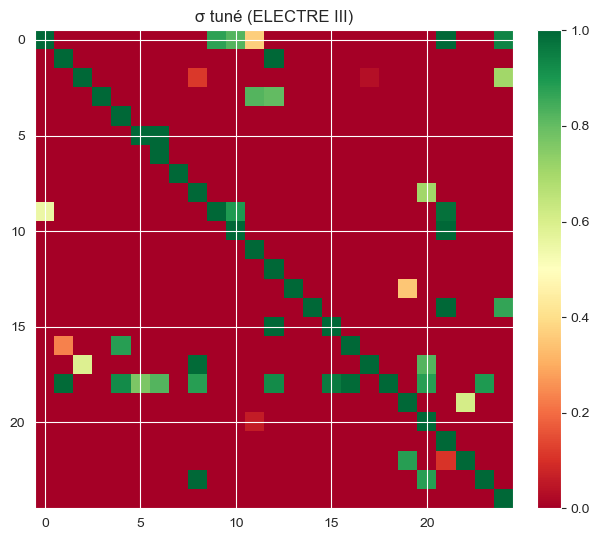

In [34]:
# Cellule 25bis - Diagnostics d'asymétrie et tuning des seuils ELECTRE
print("=" * 70)
print("🔧 Diagnostics & tuning — asymétrie de σ et recalage des seuils")
print("=" * 70)


# Prérequis
needed = ['sigma','perf_norm','electre_criteria','electre_maximize','weights']
missing = [n for n in needed if n not in globals()]
if missing:
    raise NameError(f"Variables manquantes pour tuning: {missing}")

# 1) Diagnostic d'asymétrie de σ
asym = sigma - sigma.T
asym_mean = np.nanmean(asym.values)
asym_abs_mean = np.nanmean(np.abs(asym.values))
print(f"Asymétrie moyenne σ-σᵀ: {asym_mean:.4f}")
print(f"Asymétrie moyenne absolue |σ-σᵀ|: {asym_abs_mean:.4f}")

# 2) Duplicats de profils de performances
dup_count = int(perf_norm.duplicated().sum())
print(f"Profils strictement dupliqués dans perf_norm: {dup_count}")

# 3) Tuning des seuils par dispersion des critères (IQR sur perf_norm)
iqr = perf_norm.quantile(0.75) - perf_norm.quantile(0.25)
thresholds_tuned = {}
for c in electre_criteria:
    spread = float(iqr.get(c, 0.0))
    # Ajustements proportionnels + planchers pour éviter q=p=v
    q = max(0.02, 0.05 * spread)
    p = max(q + 0.02, 0.15 * spread)
    v = max(p + 0.02, 0.30 * spread)
    # Tronquer à [0,1]
    q = float(np.clip(q, 0.0, 1.0))
    p = float(np.clip(p, 0.0, 1.0))
    v = float(np.clip(v, 0.0, 1.0))
    # Garantir ordre q<=p<=v
    p = max(p, q)
    v = max(v, p)
    thresholds_tuned[c] = {'q': q, 'p': p, 'v': v}

print("Seuils tunés (extrait):")
for c in list(thresholds_tuned.keys())[:5]:
    t = thresholds_tuned[c]
    print(f"  {c}: q={t['q']:.3f}, p={t['p']:.3f}, v={t['v']:.3f}")

# 4) Recalcul de σ et du classement avec seuils tunés
sigma_tuned = electre3_sigma(perf_norm, electre_criteria, electre_maximize, weights, thresholds_tuned)
ranking_tuned = netflow_ranking(sigma_tuned)

# 5) Comparaison net flow
def _nf_stats(name, r):
    s = r['phi_netflow'] if isinstance(r, pd.DataFrame) else r
    print(f"\n{name} — stats net flow:")
    print(f"  • Max: {s.max():.4f}")
    print(f"  • Q3:  {s.quantile(0.75):.4f}")
    print(f"  • Med: {s.median():.4f}")
    print(f"  • Q1:  {s.quantile(0.25):.4f}")
    print(f"  • Min: {s.min():.4f}")

if 'ranking' in globals():
    _nf_stats('Original', ranking)
_nf_stats('Tuné', ranking_tuned)

# 6) Corrélation de rangs (si classement original disponible)
if 'ranking' in globals():
    comp = ranking.join(ranking_tuned, lsuffix='_orig', rsuffix='_tuned', how='inner')
    if len(comp) >= 2:
        comp['rank_orig']  = comp['phi_netflow_orig'].rank(ascending=False)
        comp['rank_tuned'] = comp['phi_netflow_tuned'].rank(ascending=False)
        rho = comp[['rank_orig','rank_tuned']].corr(method='spearman').iloc[0,1]
        tau = comp[['rank_orig','rank_tuned']].corr(method='kendall').iloc[0,1]
        print("\nCorrélation de rangs (original vs tuné):")
        print(f"  • Spearman ρ: {rho:.3f}")
        print(f"  • Kendall τ:  {tau:.3f}")
    else:
        print("\nCorrélation de rangs: trop peu d'actions communes.")

# 7) Heatmap rapide de σ tuné (optionnelle)
fig, ax = plt.subplots(figsize=(6.5, 5.5))
im = ax.imshow(sigma_tuned.values, vmin=0, vmax=1, cmap='RdYlGn')
ax.set_title("σ tuné (ELECTRE III)")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

➕ Méthode additive compensatoire — Score pondéré
Top 10 (méthode additive compensatoire):
                    score_additif
action_id                        
nan_23/05/2025_107          10.94
nan_18/06/2025_77            9.55
nan_07/02/2025_116           8.69
nan_07/05/2025_116           8.33
nan_20/02/2025_120           8.23
nan_28/04/2025_650           8.04
nan_02/06/2025_551           7.83
nan_21/02/2025_42            7.63
nan_19/04/2025_117           7.41
nan_01/04/2025_598           7.27

Statistiques des scores additifs:
  • Score moyen:   6.8124
  • Score médian:  6.8307
  • Écart-type:    1.6991
  • Min/Max:       3.5795 / 10.9368

Comparaison avec ELECTRE (corrélation de rangs):
  • Spearman ρ: 0.781
  • Kendall τ:  0.660


➕ Méthode additive compensatoire — Score pondéré
Top 10 (méthode additive compensatoire):
                    score_additif
action_id                        
nan_23/05/2025_107          10.94
nan_18/06/2025_77            9.55
nan_07/02/2025_116           8.69
nan_07/05/2025_116           8.33
nan_20/02/2025_120           8.23
nan_28/04/2025_650           8.04
nan_02/06/2025_551           7.83
nan_21/02/2025_42            7.63
nan_19/04/2025_117           7.41
nan_01/04/2025_598           7.27

Statistiques des scores additifs:
  • Score moyen:   6.8124
  • Score médian:  6.8307
  • Écart-type:    1.6991
  • Min/Max:       3.5795 / 10.9368

Comparaison avec ELECTRE (corrélation de rangs):
  • Spearman ρ: 0.781
  • Kendall τ:  0.660


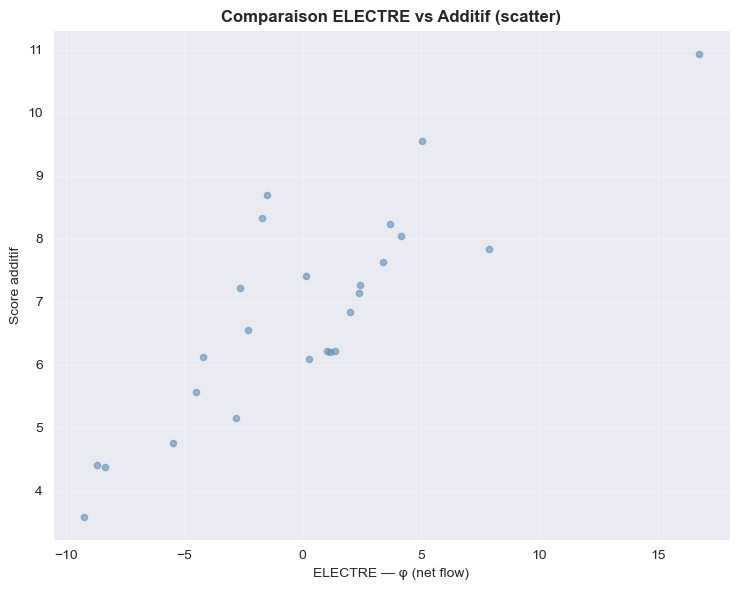

In [35]:
# Cellule 26 - Méthode additive compensatoire (améliorée)
print("=" * 70)
print("➕ Méthode additive compensatoire — Score pondéré")
print("=" * 70)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paramètres de la section
EXPORT_ADD_SCORE_CSV = False        # Export optionnel des scores additifs
ADD_SCORE_CSV_PATH = "scores_additif.csv"
SCATTER_CAP = 5000                  # Limite d'affichage pour le scatter

# 1) Validations et alignements
missing_vars = []
for name in ["weights", "perf_norm"]:
    if name not in locals():
        missing_vars.append(name)
if missing_vars:
    raise NameError(f"Variables manquantes: {missing_vars}")

if not isinstance(perf_norm, pd.DataFrame):
    raise TypeError("perf_norm doit être un DataFrame")

# Convertir performances en numériques et gérer NaN
perf_work = perf_norm.copy()
for c in perf_work.columns:
    perf_work[c] = pd.to_numeric(perf_work[c], errors='coerce')
if perf_work.isna().any().any():
    na_before = perf_work.isna().sum().sum()
    perf_work = perf_work.fillna(perf_work.mean(numeric_only=True))
    print(f"  ℹ️  {na_before} valeurs manquantes remplacées par la moyenne de colonne.")

# Aligner poids ↔ critères
w_series = pd.Series(weights, dtype=float)
common_cols = [c for c in perf_work.columns if c in w_series.index]
missing_w = [c for c in perf_work.columns if c not in w_series.index]
extra_w = [c for c in w_series.index if c not in perf_work.columns]

if missing_w:
    print(f"  ⚠️  Poids manquants ignorés pour critères: {missing_w}")
if extra_w:
    print(f"  ℹ️  Poids sans critère dans perf_norm ignorés: {extra_w}")

if not common_cols:
    raise ValueError("Aucun critère commun entre perf_norm et weights.")

w_used = w_series.reindex(common_cols)
# 2) Calcul du score additif
score_add = (perf_work[common_cols] * w_used).sum(axis=1).to_frame(name="score_additif")
score_add = score_add.sort_values(by="score_additif", ascending=False)

# 3) Statistiques descriptives
print("Top 10 (méthode additive compensatoire):")
print(score_add.head(10).to_string())

print("\nStatistiques des scores additifs:")
print(f"  • Score moyen:   {score_add['score_additif'].mean():.4f}")
print(f"  • Score médian:  {score_add['score_additif'].median():.4f}")
print(f"  • Écart-type:    {score_add['score_additif'].std():.4f}")
print(f"  • Min/Max:       {score_add['score_additif'].min():.4f} / {score_add['score_additif'].max():.4f}")

# 4) Comparaison avec ELECTRE (si ranking disponible)
if 'ranking' in locals() and isinstance(ranking, pd.DataFrame) and 'phi_netflow' in ranking.columns:
    comp = score_add.join(ranking, how='inner')
    if len(comp) >= 2:
        # Corrélations de rang entre méthodes
        # Rang inverse pour score_additif (plus grand = meilleur), idem pour phi_netflow
        comp['rank_add'] = comp['score_additif'].rank(ascending=False, method='average')
        comp['rank_phi'] = comp['phi_netflow'].rank(ascending=False, method='average')
        rho = comp[['rank_add','rank_phi']].corr(method='spearman').iloc[0,1]
        tau = comp[['rank_add','rank_phi']].corr(method='kendall').iloc[0,1]
        print("\nComparaison avec ELECTRE (corrélation de rangs):")
        print(f"  • Spearman ρ: {rho:.3f}")
        print(f"  • Kendall τ:  {tau:.3f}")
        
        # Option: Scatter des scores
        comp_plot = comp.copy()
        if len(comp_plot) > SCATTER_CAP:
            comp_plot = comp_plot.sample(SCATTER_CAP, random_state=42)
            print(f"  ℹ️  Échantillonnage scatter: {SCATTER_CAP} points sur {len(comp)}.")
        fig, ax = plt.subplots(figsize=(7.5, 6))
        ax.scatter(comp_plot['phi_netflow'], comp_plot['score_additif'], alpha=0.5, s=20, color='steelblue')
        ax.set_xlabel("ELECTRE — φ (net flow)")
        ax.set_ylabel("Score additif")
        ax.set_title("Comparaison ELECTRE vs Additif (scatter)", fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("\nComparaison avec ELECTRE impossible (trop peu d'actions communes).")
else:
    print("\nRanking ELECTRE indisponible — comparaison sautée.")

# 5) Export optionnel
if EXPORT_ADD_SCORE_CSV:
    try:
        score_add.to_csv(ADD_SCORE_CSV_PATH, index=True)
        print(f"  ✓ Scores additifs exportés: {ADD_SCORE_CSV_PATH}")
    except Exception as e:
        print(f"  ⚠️  Échec export CSV: {e}")

## 11. Comparaison avec une méthode compensatoire et documentation

On compare ELECTRE III à un score additif pondéré (somme pondérée) calculé sur les mêmes critères normalisés et les mêmes poids.  
On examine :  
- le Top‑10 additif,  
- le recouvrement avec le Top‑10 ELECTRE (taux d’accord),  
- les différences de rangs.  

On documente également chaque critère (sens, unité, source, dimension) dans une table CRITERIA_META et on exporte l’ensemble des résultats vers un fichier Excel pour exploitation dans le rapport.


➕ Méthode additive compensatoire — Score pondéré
Top 10 (méthode additive compensatoire):
                    score_additif
action_id                        
nan_23/05/2025_107          10.94
nan_18/06/2025_77            9.55
nan_07/02/2025_116           8.69
nan_07/05/2025_116           8.33
nan_20/02/2025_120           8.23
nan_28/04/2025_650           8.04
nan_02/06/2025_551           7.83
nan_21/02/2025_42            7.63
nan_19/04/2025_117           7.41
nan_01/04/2025_598           7.27

Statistiques des scores additifs:
  • Score moyen:   6.8124
  • Score médian:  6.8307
  • Écart-type:    1.6991
  • Min/Max:       3.5795 / 10.9368

Comparaison avec ELECTRE (corrélation de rangs):
  • Spearman ρ: 0.781
  • Kendall τ:  0.660


➕ Méthode additive compensatoire — Score pondéré
Top 10 (méthode additive compensatoire):
                    score_additif
action_id                        
nan_23/05/2025_107          10.94
nan_18/06/2025_77            9.55
nan_07/02/2025_116           8.69
nan_07/05/2025_116           8.33
nan_20/02/2025_120           8.23
nan_28/04/2025_650           8.04
nan_02/06/2025_551           7.83
nan_21/02/2025_42            7.63
nan_19/04/2025_117           7.41
nan_01/04/2025_598           7.27

Statistiques des scores additifs:
  • Score moyen:   6.8124
  • Score médian:  6.8307
  • Écart-type:    1.6991
  • Min/Max:       3.5795 / 10.9368

Comparaison avec ELECTRE (corrélation de rangs):
  • Spearman ρ: 0.781
  • Kendall τ:  0.660


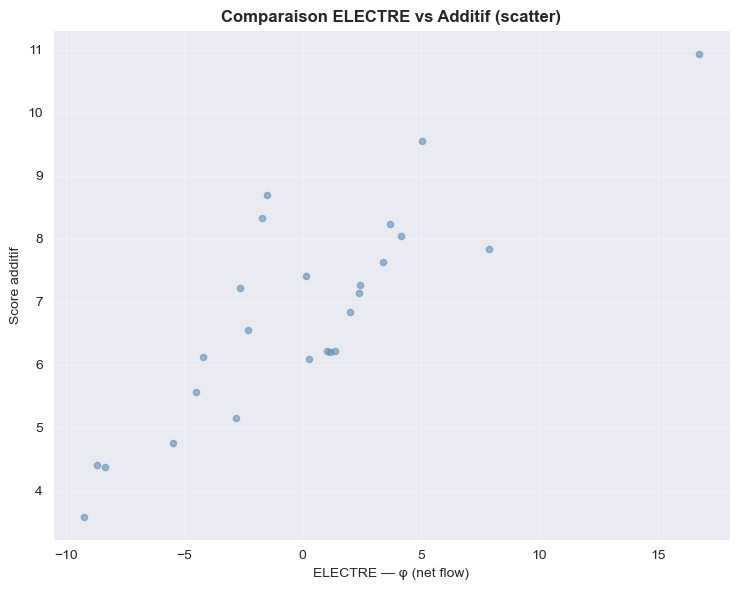

In [36]:
# Cellule 27 - Méthode additive compensatoire (améliorée)
print("=" * 70)
print("➕ Méthode additive compensatoire — Score pondéré")
print("=" * 70)

# Paramètres de la section
NORMALIZE_WEIGHTS = False           # PAS de normalisation des poids
EXPORT_ADD_SCORE_CSV = False
ADD_SCORE_CSV_PATH = "scores_additif.csv"
SCATTER_CAP = 5000

# 1) Validations et alignements
missing_vars = []
for name in ["weights", "perf_norm"]:
    if name not in globals():
        missing_vars.append(name)
if missing_vars:
    raise NameError(f"Variables manquantes: {missing_vars}")

if not isinstance(perf_norm, pd.DataFrame):
    raise TypeError("perf_norm doit être un DataFrame")

# Convertir performances en numériques et gérer NaN
perf_work = perf_norm.copy()
for c in perf_work.columns:
    perf_work[c] = pd.to_numeric(perf_work[c], errors="coerce")
if perf_work.isna().any().any():
    na_before = perf_work.isna().sum().sum()
    perf_work = perf_work.fillna(perf_work.mean(numeric_only=True))
    print(f"  ℹ️  {na_before} valeurs manquantes remplacées par la moyenne de colonne.")

# Aligner poids ↔ critères
w_series = pd.Series(weights, dtype=float)
common_cols = [c for c in perf_work.columns if c in w_series.index]
missing_w = [c for c in perf_work.columns if c not in w_series.index]
extra_w = [c for c in w_series.index if c not in perf_work.columns]

if missing_w:
    print(f"  ⚠️  Poids manquants ignorés pour critères: {missing_w}")
if extra_w:
    print(f"  ℹ️  Poids sans critère dans perf_norm ignorés: {extra_w}")

if not common_cols:
    raise ValueError("Aucun critère commun entre perf_norm et weights.")

w_used = w_series.reindex(common_cols)
# Pas de normalisation des poids : on utilise directement les niveaux 3 / 2 / 1

# 2) Calcul du score additif
score_add = (perf_work[common_cols] * w_used).sum(axis=1).to_frame(name="score_additif")
score_add = score_add.sort_values(by="score_additif", ascending=False)

# 3) Statistiques descriptives
print("Top 10 (méthode additive compensatoire):")
print(score_add.head(10).to_string())

print("\nStatistiques des scores additifs:")
print(f"  • Score moyen:   {score_add['score_additif'].mean():.4f}")
print(f"  • Score médian:  {score_add['score_additif'].median():.4f}")
print(f"  • Écart-type:    {score_add['score_additif'].std():.4f}")
print(f"  • Min/Max:       {score_add['score_additif'].min():.4f} / {score_add['score_additif'].max():.4f}")

# 4) Comparaison avec ELECTRE (si ranking disponible)
if "ranking" in globals() and isinstance(ranking, pd.DataFrame) and "phi_netflow" in ranking.columns:
    comp = score_add.join(ranking, how="inner")
    if len(comp) >= 2:
        comp["rank_add"] = comp["score_additif"].rank(ascending=False, method="average")
        comp["rank_phi"] = comp["phi_netflow"].rank(ascending=False, method="average")
        rho = comp[["rank_add", "rank_phi"]].corr(method="spearman").iloc[0, 1]
        tau = comp[["rank_add", "rank_phi"]].corr(method="kendall").iloc[0, 1]
        print("\nComparaison avec ELECTRE (corrélation de rangs):")
        print(f"  • Spearman ρ: {rho:.3f}")
        print(f"  • Kendall τ:  {tau:.3f}")

        comp_plot = comp.copy()
        if len(comp_plot) > SCATTER_CAP:
            comp_plot = comp_plot.sample(SCATTER_CAP, random_state=42)
            print(f"  ℹ️  Échantillonnage scatter: {SCATTER_CAP} points sur {len(comp)}.")
        fig, ax = plt.subplots(figsize=(7.5, 6))
        ax.scatter(comp_plot["phi_netflow"], comp_plot["score_additif"], alpha=0.5, s=20, color="steelblue")
        ax.set_xlabel("ELECTRE — φ (net flow)")
        ax.set_ylabel("Score additif")
        ax.set_title("Comparaison ELECTRE vs Additif (scatter)", fontsize=12, fontweight="bold")
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("\nComparaison avec ELECTRE impossible (trop peu d'actions communes).")
else:
    print("\nRanking ELECTRE indisponible — comparaison sautée.")

# 5) Export optionnel
if EXPORT_ADD_SCORE_CSV:
    try:
        score_add.to_csv(ADD_SCORE_CSV_PATH, index=True)
        print(f"  ✓ Scores additifs exportés: {ADD_SCORE_CSV_PATH}")
    except Exception as e:
        print(f"  ⚠️  Échec export CSV: {e}")


In [37]:
# Cellule 28 - Export complet des résultats (amélioré)
print("=" * 70)
print("📊 Export complet des résultats ELECTRE III")
print("=" * 70)

import pandas as pd
import numpy as np

# Paramètres d'export
ENABLE_EXCEL_EXPORT = True          # Activer/désactiver l'export Excel
EXCEL_OUTPUT_PATH = "electre_outputs.xlsx"
DEDUP_BEFORE_SYNTH = True           # Dédupliquer ac_work avant synthèse

# 1) Validation des variables requises
required_vars = {
    "ac_work": "DataFrame des actions avec critères",
    "ranking": "DataFrame du classement ELECTRE (phi_netflow)",
    "score_add": "DataFrame des scores additifs",
    "noyau": "DataFrame du noyau ELECTRE"
}

missing = []
for var_name, desc in required_vars.items():
    if var_name not in globals():
        missing.append(f"{var_name} ({desc})")

if missing:
    print("⚠️  Variables manquantes pour export complet:")
    for m in missing:
        print(f"   - {m}")
    raise NameError(f"Impossible de créer la synthèse sans: {', '.join([m.split()[0] for m in missing])}")

# Vérifications de type
if not isinstance(ac_work, pd.DataFrame):
    raise TypeError("ac_work doit être un DataFrame")
if not isinstance(ranking, pd.DataFrame) or "phi_netflow" not in ranking.columns:
    raise ValueError("ranking doit contenir la colonne 'phi_netflow'")
if not isinstance(score_add, pd.DataFrame) or "score_additif" not in score_add.columns:
    raise ValueError("score_add doit contenir la colonne 'score_additif'")
if not isinstance(noyau, pd.DataFrame):
    raise TypeError("noyau doit être un DataFrame")

print("✓ Toutes les variables requises sont présentes.\n")

# 2) Préparation de la synthèse avec gestion des index
print("📋 Construction de la table de synthèse...")

# Dédupliquer ac_work si activé (garde meilleure action par action_id)
ac_export = ac_work.copy()
if DEDUP_BEFORE_SYNTH and "action_id" in ac_export.columns:
    n_before = len(ac_export)
    sort_cols = []
    for c in ["rentabilite", "cashflow", "phi_netflow"]:
        if c in ac_export.columns:
            sort_cols.append(c)
    if sort_cols:
        ac_export = ac_export.sort_values(sort_cols, ascending=False)
    ac_export = ac_export.drop_duplicates(subset=["action_id"], keep="first")
    n_after = len(ac_export)
    if n_after < n_before:
        print(f"  ℹ️  Déduplication: {n_before} → {n_after} actions ({n_before - n_after} doublons retirés)")

# Créer l'index action_id pour ac_export
if "action_id" not in ac_export.columns:
    print("  ⚠️  Colonne 'action_id' absente de ac_work, utilisation de l'index existant.")
    synth = ac_export.copy()
else:
    synth = ac_export.set_index("action_id", drop=True).copy()

# Joindre phi_netflow depuis ranking
if len(ranking) > 0:
    # Aligner les index
    common_ids = synth.index.intersection(ranking.index)
    if len(common_ids) == 0:
        print("  ⚠️  Aucun action_id commun entre synth et ranking, phi_netflow sera NaN.")
    synth["phi_netflow"] = np.nan
    synth.loc[common_ids, "phi_netflow"] = ranking.loc[common_ids, "phi_netflow"]
else:
    synth["phi_netflow"] = np.nan
    print("  ⚠️  ranking vide, phi_netflow non disponible.")

# Joindre score_additif depuis score_add
if len(score_add) > 0:
    common_ids_add = synth.index.intersection(score_add.index)
    if len(common_ids_add) == 0:
        print("  ⚠️  Aucun action_id commun entre synth et score_add, score_additif sera NaN.")
    synth["score_additif"] = np.nan
    synth.loc[common_ids_add, "score_additif"] = score_add.loc[common_ids_add, "score_additif"]
else:
    synth["score_additif"] = np.nan
    print("  ⚠️  score_add vide, score_additif non disponible.")

# Extraire les IDs du noyau (robuste multi-colonne)
if len(noyau) > 0:
    noyau_id_col = None
    for cand in ["action_id", "id", "ID"]:
        if cand in noyau.columns:
            noyau_id_col = cand
            break
    if noyau_id_col is None:
        noyau_ids = noyau.index.astype(str).values.tolist()
        print(f"  ℹ️  Colonne action_id non trouvée dans noyau, utilisation de l'index ({len(noyau_ids)} IDs)")
    else:
        noyau_ids = noyau[noyau_id_col].astype(str).values.tolist()
else:
    noyau_ids = []
    print("  ⚠️  noyau vide, aucune action dans le noyau.")

synth["is_in_noyau"] = synth.index.astype(str).isin(noyau_ids)

# Calculer les rangs
synth["rang_electre"] = synth["phi_netflow"].rank(ascending=False, method="min")
synth["rang_additif"] = synth["score_additif"].rank(ascending=False, method="min")

print(f"✓ Synthèse créée: {len(synth)} actions, {synth['is_in_noyau'].sum()} dans le noyau.\n")

# 3) Export Excel avec gestion d'erreur par feuille
if ENABLE_EXCEL_EXPORT:
    print(f"📤 Export vers '{EXCEL_OUTPUT_PATH}'...")
    sheets_exported = []
    sheets_failed = []
    
    try:
        with pd.ExcelWriter(EXCEL_OUTPUT_PATH, engine="openpyxl") as writer:
            # Feuille 1: actions et critères
            try:
                ac_export.reset_index(drop=True).to_excel(writer, sheet_name="actions_criteria", index=False)
                sheets_exported.append("actions_criteria")
            except Exception as e:
                sheets_failed.append(("actions_criteria", str(e)))
            
            # Feuille 2: performances normalisées
            if "perf_norm" in globals() and isinstance(perf_norm, pd.DataFrame):
                try:
                    perf_norm.to_excel(writer, sheet_name="perf_norm", index=True)
                    sheets_exported.append("perf_norm")
                except Exception as e:
                    sheets_failed.append(("perf_norm", str(e)))
            else:
                sheets_failed.append(("perf_norm", "Variable non définie"))
            
            # Feuille 3: matrice de crédibilité
            if "sigma" in globals() and isinstance(sigma, pd.DataFrame):
                try:
                    sigma.to_excel(writer, sheet_name="sigma", index=True)
                    sheets_exported.append("sigma")
                except Exception as e:
                    sheets_failed.append(("sigma", str(e)))
            else:
                sheets_failed.append(("sigma", "Variable non définie"))
            
            # Feuille 4: classement net flow
            try:
                ranking.to_excel(writer, sheet_name="ranking_netflow", index=True)
                sheets_exported.append("ranking_netflow")
            except Exception as e:
                sheets_failed.append(("ranking_netflow", str(e)))
            
            # Feuille 5: synthèse complète
            try:
                synth.reset_index().to_excel(writer, sheet_name="synthese", index=False)
                sheets_exported.append("synthese")
            except Exception as e:
                sheets_failed.append(("synthese", str(e)))
            
            # Feuille 6: noyau
            try:
                noyau.to_excel(writer, sheet_name="noyau", index=False)
                sheets_exported.append("noyau")
            except Exception as e:
                sheets_failed.append(("noyau", str(e)))
        
        print(f"✓ Fichier créé avec succès: '{EXCEL_OUTPUT_PATH}'")
        print(f"  • Feuilles exportées ({len(sheets_exported)}): {', '.join(sheets_exported)}")
        print(f"  • Actions analysées: {len(ac_export)}")
        if sheets_failed:
            print(f"  ⚠️  Feuilles échouées ({len(sheets_failed)}):")
            for sheet, err in sheets_failed:
                print(f"      - {sheet}: {err}")
    except Exception as e:
        print(f"❌ Échec de la création du fichier Excel: {e}")
else:
    print("  ℹ️  Export Excel désactivé (ENABLE_EXCEL_EXPORT=False)\n")

# 4) Affichage des résultats - multiple vues
print("\n" + "=" * 70)
print("🏆 Résultats principaux")
print("=" * 70)

# Colonnes d'affichage (sélection dynamique)
display_base = ["ville", "type_local", "rentabilite", "cashflow", "prix_m2"]
display_scores = ["phi_netflow", "score_additif", "is_in_noyau"]
display_cols = [c for c in display_base if c in synth.columns] + display_scores

# Vue 1: Top 10 ELECTRE
print("\n🥇 Top 10 par classement ELECTRE (phi_netflow):")
top_electre = synth.dropna(subset=["phi_netflow"]).sort_values("phi_netflow", ascending=False).head(10)
if len(top_electre) > 0:
    print(top_electre[display_cols].to_string())
else:
    print("  ⚠️  Aucune action avec phi_netflow valide.")

# Vue 2: Top 10 Additif
print("\n🥈 Top 10 par méthode additive (score_additif):")
top_add = synth.dropna(subset=["score_additif"]).sort_values("score_additif", ascending=False).head(10)
if len(top_add) > 0:
    print(top_add[display_cols].to_string())
else:
    print("  ⚠️  Aucune action avec score_additif valide.")

# Vue 3: Actions du noyau
print(f"\n🎯 Actions du noyau ELECTRE ({synth['is_in_noyau'].sum()} actions):")
noyau_view = synth[synth["is_in_noyau"]].sort_values("phi_netflow", ascending=False)
if len(noyau_view) > 0:
    print(noyau_view[display_cols].head(15).to_string())
else:
    print("  ⚠️  Noyau vide.")

# Statistiques de synthèse
print("\n" + "=" * 70)
print("📈 Statistiques de synthèse")
print("=" * 70)
if synth["phi_netflow"].notna().sum() > 0:
    print(f"ELECTRE (φ net flow):")
    print(f"  • Moyenne:  {synth['phi_netflow'].mean():.4f}")
    print(f"  • Médiane:  {synth['phi_netflow'].median():.4f}")
    print(f"  • Min/Max:  {synth['phi_netflow'].min():.4f} / {synth['phi_netflow'].max():.4f}")
    print(f"  • Écart-type: {synth['phi_netflow'].std():.4f}")
if synth["score_additif"].notna().sum() > 0:
    print(f"\nMéthode additive:")
    print(f"  • Moyenne:  {synth['score_additif'].mean():.4f}")
    print(f"  • Médiane:  {synth['score_additif'].median():.4f}")
    print(f"  • Min/Max:  {synth['score_additif'].min():.4f} / {synth['score_additif'].max():.4f}")
    print(f"  • Écart-type: {synth['score_additif'].std():.4f}")

print("\n✓ Export et synthèse terminés.")

📊 Export complet des résultats ELECTRE III
✓ Toutes les variables requises sont présentes.

📋 Construction de la table de synthèse...
✓ Synthèse créée: 25 actions, 0 dans le noyau.

📤 Export vers 'electre_outputs.xlsx'...
✓ Fichier créé avec succès: 'electre_outputs.xlsx'
  • Feuilles exportées (6): actions_criteria, perf_norm, sigma, ranking_netflow, synthese, noyau
  • Actions analysées: 25

🏆 Résultats principaux

🥇 Top 10 par classement ELECTRE (phi_netflow):
                                    ville   type_local  rentabilite  cashflow  prix_m2  phi_netflow  score_additif  is_in_noyau
action_id                                                                                                                      
nan_23/05/2025_107               PARIS 07  Appartement        15.83  34051.50  2769.23        16.73          10.94        False
nan_02/06/2025_551  SAINT-GERMAIN-EN-LAYE  Appartement        13.87  19673.02  2035.89         7.87           7.83        False
nan_18/06/2025_77   

## 12. Analyse de sensibilité et synthèse des résultats

Pour évaluer la robustesse des recommandations, on définit un profil de poids “prudent” qui renforce la liquidité et le risque travaux.  
On recalcule ELECTRE III avec ces nouveaux poids et on compare :  
- les scores de net flow (corrélation avec le scénario de base),  
- la composition du noyau,  
- le Top‑10 obtenu.  

Enfin, on produit un résumé global (taille de l’échantillon, taille du front de Pareto, statistiques sur les critères) et on exporte tous les résultats (base, prudent) dans un classeur Excel unique.


🔬 Analyse de sensibilité — Profil 'prudent'
Ce profil renforce la liquidité et l'attractivité du quartier.

🔍 Validation des prérequis...
✓ Toutes les variables requises sont présentes.

⚙️  Configuration des poids...

📊 Poids prudents vs base:
  Critère                  Base  Prudent    Delta
  --------------------------------------------------
  rentabilite           300.0%   20.0% -280.0%
  cashflow              300.0%   20.0% -280.0%
  liquidite             300.0%   20.0% -280.0%
  indice_quartier       200.0%   15.0% -185.0%
  prix_m2               200.0%   10.0% -190.0%
  loyer_m2              200.0%    5.0% -195.0%
  loyer_annuel          100.0%    5.0%  -95.0%
  type_score            100.0%    5.0%  -95.0%

🧮 Calcul ELECTRE III (profil prudent)...
Calcul de la matrice ELECTRE III sur 25 actions et 8 critères...
✓ Matrice de crédibilité σ calculée
  • Moyenne σ: 0.187
  • Médiane σ: 0.000
  ✓ Matrice σ prudent calculée: 25 actions

Distribution des scores net flow φ(a) :
  • Max

🔬 Analyse de sensibilité — Profil 'prudent'
Ce profil renforce la liquidité et l'attractivité du quartier.

🔍 Validation des prérequis...
✓ Toutes les variables requises sont présentes.

⚙️  Configuration des poids...

📊 Poids prudents vs base:
  Critère                  Base  Prudent    Delta
  --------------------------------------------------
  rentabilite           300.0%   20.0% -280.0%
  cashflow              300.0%   20.0% -280.0%
  liquidite             300.0%   20.0% -280.0%
  indice_quartier       200.0%   15.0% -185.0%
  prix_m2               200.0%   10.0% -190.0%
  loyer_m2              200.0%    5.0% -195.0%
  loyer_annuel          100.0%    5.0%  -95.0%
  type_score            100.0%    5.0%  -95.0%

🧮 Calcul ELECTRE III (profil prudent)...
Calcul de la matrice ELECTRE III sur 25 actions et 8 critères...
✓ Matrice de crédibilité σ calculée
  • Moyenne σ: 0.187
  • Médiane σ: 0.000
  ✓ Matrice σ prudent calculée: 25 actions

Distribution des scores net flow φ(a) :
  • Max

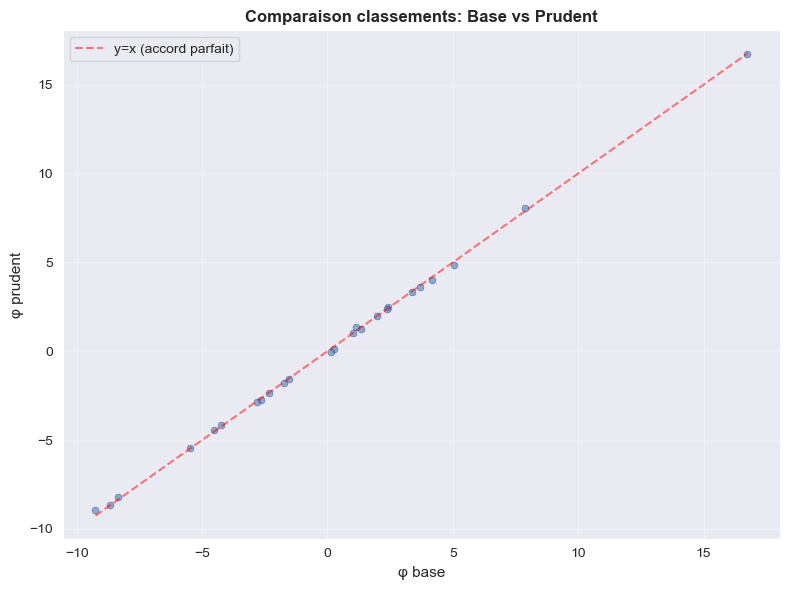


🏆 Top 10 actions

📌 Top prudent (phi_netflow_prudent):
                    phi_prudent
nan_23/05/2025_107        16.74
nan_02/06/2025_551         8.06
nan_18/06/2025_77          4.83
nan_28/04/2025_650         3.99
nan_20/02/2025_120         3.59
nan_21/02/2025_42          3.33
nan_01/04/2025_598         2.49
nan_12/03/2025_674         2.39
nan_02/06/2025_54          1.98
nan_12/06/2025_500         1.35

📌 Top base (phi_netflow):
                    phi_netflow
nan_23/05/2025_107        16.73
nan_02/06/2025_551         7.87
nan_18/06/2025_77          5.04
nan_28/04/2025_650         4.15
nan_20/02/2025_120         3.67
nan_21/02/2025_42          3.38
nan_01/04/2025_598         2.40
nan_12/03/2025_674         2.36
nan_02/06/2025_54          1.99
nan_17/04/2025_642         1.35

📉 Statistiques des scores φ
Scénario   Moyenne  Médiane  Écart-type   Min   Max
    Base  7.11e-17     0.25        5.60 -9.25 16.73
 Prudent -4.26e-16     0.11        5.57 -8.92 16.74

✓ Analyse de sensibilité te

In [38]:
# Cellule 29 - Analyse de sensibilité: profil "prudent" (amélioré)
print("=" * 70)
print("🔬 Analyse de sensibilité — Profil 'prudent'")
print("=" * 70)
print("Ce profil renforce la liquidité et l'attractivité du quartier.\n")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kendalltau

# Paramètres de l'analyse de sensibilité
LAMBDA_PRUDENT = 0.6           # Seuil lambda pour kernel prudent
SHOW_TOP_N = 10                # Nombre d'actions à afficher dans les comparaisons
SCATTER_CAP = 5000             # Limite points pour scatter plot

# 1) Validation des variables requises
print("🔍 Validation des prérequis...")
required_vars = {
    "perf_norm": pd.DataFrame,
    "electre_criteria": list,
    "electre_maximize": dict,
    "thresholds": dict,
    "electre3_sigma": type(lambda: None),  # function
    "netflow_ranking": type(lambda: None),
    "electre_kernel": type(lambda: None),
}

missing = []
for var_name, expected_type in required_vars.items():
    if var_name not in globals():
        missing.append(var_name)
    elif expected_type in [pd.DataFrame, list, dict] and not isinstance(globals()[var_name], expected_type):
        missing.append(f"{var_name} (mauvais type)")

if missing:
    print(f"⚠️  Variables manquantes ou invalides: {', '.join(missing)}")
    raise NameError(f"Impossible d'effectuer l'analyse de sensibilité sans: {', '.join(missing)}")

# Vérifier si noyau_ids et ranking existent (résultats de base)
has_baseline_results = 'noyau_ids' in globals() and 'ranking' in globals()
if not has_baseline_results:
    print("⚠️  noyau_ids ou ranking non définis, comparaison limitée.")

print("✓ Toutes les variables requises sont présentes.\n")

# 2) Définir les poids prudents avec gestion des poids de base
print("⚙️  Configuration des poids...")

# Poids de base (si non définis, utiliser valeurs par défaut)
if 'weights' not in globals():
    weights = {
        "rentabilite":     0.25,
        "cashflow":        0.25,
        "prix_m2":         0.10,
        "loyer_m2":        0.10,
        "loyer_annuel":    0.05,
        "liquidite":       0.10,
        "type_score":      0.05,
        "indice_quartier": 0.10,
    }
    print("  ℹ️  Poids de base créés avec valeurs par défaut.")

# Poids prudents: renforce liquidité et attractivité, réduit rentabilité/cashflow
weights_prudent = {
    "rentabilite":     0.20,  # -5% (moins d'accent sur rendement)
    "cashflow":        0.20,  # -5% (moins d'accent sur trésorerie)
    "prix_m2":         0.10,  # stable
    "loyer_m2":        0.05,  # -5% (moins important)
    "loyer_annuel":    0.05,  # stable
    "liquidite":       0.20,  # +10% (plus de sécurité)
    "type_score":      0.05,  # stable
    "indice_quartier": 0.15,  # +5% (plus d'attractivité)
}

# Normaliser les poids prudents
total_weight = sum(weights_prudent.values())
if total_weight == 0:
    raise ValueError("Somme des poids prudents nulle.")
weights_prudent = {k: v / total_weight for k, v in weights_prudent.items()}

# Afficher les différences
print("\n📊 Poids prudents vs base:")
print(f"  {'Critère':<20} {'Base':>8} {'Prudent':>8} {'Delta':>8}")
print("  " + "-" * 50)
for c in sorted(weights_prudent.keys(), key=lambda x: -weights_prudent[x]):
    w_base = weights.get(c, 0)
    w_prud = weights_prudent[c]
    delta = w_prud - w_base
    print(f"  {c:<20} {w_base:>7.1%} {w_prud:>7.1%} {delta:>+7.1%}")

# 3) Calcul ELECTRE III avec poids prudents
print("\n🧮 Calcul ELECTRE III (profil prudent)...")
try:
    sigma_prudent = electre3_sigma(
        perf_norm,
        electre_criteria,
        electre_maximize,
        weights_prudent,
        thresholds,
    )
    print(f"  ✓ Matrice σ prudent calculée: {sigma_prudent.shape[0]} actions")
except Exception as e:
    print(f"  ❌ Échec calcul σ prudent: {e}")
    raise

try:
    ranking_prudent = netflow_ranking(sigma_prudent)
    print(f"  ✓ Classement prudent: {len(ranking_prudent)} actions")
except Exception as e:
    print(f"  ❌ Échec calcul ranking prudent: {e}")
    raise

try:
    noyau_ids_prudent = electre_kernel(sigma_prudent, lambda_cut=LAMBDA_PRUDENT)
    print(f"  ✓ Noyau prudent (λ={LAMBDA_PRUDENT}): {len(noyau_ids_prudent)} actions")
except Exception as e:
    print(f"  ❌ Échec extraction noyau prudent: {e}")
    noyau_ids_prudent = []

# 4) Comparaison des résultats
print("\n" + "=" * 70)
print("📈 Comparaison Base vs Prudent")
print("=" * 70)

# Comparaison des tailles de noyaux
if has_baseline_results:
    print("\n🎯 Taille des noyaux:")
    print(f"  • Noyau base:    {len(noyau_ids):>4} actions")
    print(f"  • Noyau prudent: {len(noyau_ids_prudent):>4} actions")
    
    # Normaliser les IDs (flatten et convert to str pour hashabilité)
    def normalize_ids(ids_list):
        """Convertit une liste d'IDs en set de strings hashables."""
        normalized = []
        for item in ids_list:
            if isinstance(item, (list, tuple)):
                # Si c'est une liste/tuple, prendre le premier élément
                normalized.extend([str(x) for x in item])
            else:
                normalized.append(str(item))
        return set(normalized)
    
    noyau_ids_set = normalize_ids(noyau_ids)
    noyau_ids_prudent_set = normalize_ids(noyau_ids_prudent)
    
    # Analyse de stabilité (intersection/union)
    common_noyau = noyau_ids_set & noyau_ids_prudent_set
    only_base = noyau_ids_set - noyau_ids_prudent_set
    only_prudent = noyau_ids_prudent_set - noyau_ids_set
    
    print("\n🔄 Stabilité des noyaux:")
    print(f"  • Communes (intersection): {len(common_noyau):>4} actions ({len(common_noyau)/max(len(noyau_ids_set),1)*100:.1f}%)")
    print(f"  • Uniquement base:         {len(only_base):>4} actions")
    print(f"  • Uniquement prudent:      {len(only_prudent):>4} actions")
    
    # Coefficient de Jaccard (similarité ensembles)
    union_noyau = noyau_ids_set | noyau_ids_prudent_set
    jaccard = len(common_noyau) / len(union_noyau) if len(union_noyau) > 0 else 0
    print(f"  • Coefficient Jaccard:     {jaccard:.3f} (similarité ensembles)")

# Comparaison des classements (corrélation de rangs)
if has_baseline_results and isinstance(ranking, pd.DataFrame) and 'phi_netflow' in ranking.columns:
    comp = ranking.join(ranking_prudent, rsuffix='_prudent', how='inner')
    if len(comp) >= 2:
        print("\n📊 Corrélation des classements (phi_netflow):")
        try:
            rho, p_spearman = spearmanr(comp['phi_netflow'], comp['phi_netflow_prudent'])
            print(f"  • Spearman ρ:  {rho:.3f} (p={p_spearman:.4f})")
        except Exception as e:
            print(f"  ⚠️  Échec Spearman: {e}")
        
        try:
            tau, p_kendall = kendalltau(comp['phi_netflow'], comp['phi_netflow_prudent'])
            print(f"  • Kendall τ:   {tau:.3f} (p={p_kendall:.4f})")
        except Exception as e:
            print(f"  ⚠️  Échec Kendall: {e}")
        
        # Scatter plot base vs prudent
        comp_plot = comp.copy()
        if len(comp_plot) > SCATTER_CAP:
            comp_plot = comp_plot.sample(SCATTER_CAP, random_state=42)
            print(f"  ℹ️  Scatter limité à {SCATTER_CAP} points sur {len(comp)}")
        
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(comp_plot['phi_netflow'], comp_plot['phi_netflow_prudent'], 
                   alpha=0.6, s=25, color='steelblue', edgecolors='darkblue', linewidth=0.3)
        
        # Ligne de référence y=x (accord parfait)
        phi_min = min(comp_plot['phi_netflow'].min(), comp_plot['phi_netflow_prudent'].min())
        phi_max = max(comp_plot['phi_netflow'].max(), comp_plot['phi_netflow_prudent'].max())
        ax.plot([phi_min, phi_max], [phi_min, phi_max], 'r--', alpha=0.5, linewidth=1.5, label='y=x (accord parfait)')
        
        ax.set_xlabel("φ base", fontsize=11)
        ax.set_ylabel("φ prudent", fontsize=11)
        ax.set_title("Comparaison classements: Base vs Prudent", fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("\n⚠️  Trop peu d'actions communes pour analyse de corrélation.")
else:
    print("\n⚠️  Classement de base non disponible, comparaison sautée.")

# 5) Top N actions - comparaison visuelle
print("\n" + "=" * 70)
print(f"🏆 Top {SHOW_TOP_N} actions")
print("=" * 70)

print("\n📌 Top prudent (phi_netflow_prudent):")
top_prudent = ranking_prudent.head(SHOW_TOP_N).copy()
if 'phi_netflow' in top_prudent.columns:
    # Renommer pour clarté
    top_prudent = top_prudent.rename(columns={'phi_netflow': 'phi_prudent'})
print(top_prudent.to_string())

if has_baseline_results and isinstance(ranking, pd.DataFrame):
    print("\n📌 Top base (phi_netflow):")
    top_base = ranking.head(SHOW_TOP_N).copy()
    print(top_base.to_string())

# Statistiques comparatives
print("\n" + "=" * 70)
print("📉 Statistiques des scores φ")
print("=" * 70)

stats_data = []
if has_baseline_results and isinstance(ranking, pd.DataFrame) and 'phi_netflow' in ranking.columns:
    stats_data.append({
        'Scénario': 'Base',
        'Moyenne': ranking['phi_netflow'].mean(),
        'Médiane': ranking['phi_netflow'].median(),
        'Écart-type': ranking['phi_netflow'].std(),
        'Min': ranking['phi_netflow'].min(),
        'Max': ranking['phi_netflow'].max(),
    })

if 'phi_netflow' in ranking_prudent.columns:
    stats_data.append({
        'Scénario': 'Prudent',
        'Moyenne': ranking_prudent['phi_netflow'].mean(),
        'Médiane': ranking_prudent['phi_netflow'].median(),
        'Écart-type': ranking_prudent['phi_netflow'].std(),
        'Min': ranking_prudent['phi_netflow'].min(),
        'Max': ranking_prudent['phi_netflow'].max(),
    })

if stats_data:
    stats_df = pd.DataFrame(stats_data)
    print(stats_df.to_string(index=False))
else:
    print("⚠️  Données statistiques insuffisantes.")

print("\n✓ Analyse de sensibilité terminée.")

⚖️  Comparaison ELECTRE III vs Méthode additive
🔍 Validation des prérequis...
✓ Toutes les variables requises sont présentes.

📊 Recouvrement des Top 10:
  • Actions communes:         7/10 (70%)
  • Uniquement ELECTRE:       3
  • Uniquement Additif:       3

✅ Actions communes aux deux Top 10:
  • nan_01/04/2025_598: SOISY SS MONTMORENCY - Maison
  • nan_02/06/2025_551: SAINT-GERMAIN-EN-LAYE - Appartement
  • nan_18/06/2025_77: VILLE-D'AVRAY - Appartement
  • nan_20/02/2025_120: PARIS 20 - Appartement
  • nan_21/02/2025_42: JOINVILLE-LE-PONT - Maison
  • nan_23/05/2025_107: PARIS 07 - Appartement
  • nan_28/04/2025_650: VESINET (LE) - Maison

📈 Corrélation des classements (sur toutes les actions)
  • Spearman ρ:  0.781 (p=0.0000)
  • Kendall τ:   0.660 (p=0.0000)
  ➜ Fort accord entre les deux méthodes

📋 Tableau comparatif (union des Top 10)
                    phi_netflow  score_additif  rang_electre  rang_additif  ecart_rang                  ville   type_local  rentabilite  cashflo

⚖️  Comparaison ELECTRE III vs Méthode additive
🔍 Validation des prérequis...
✓ Toutes les variables requises sont présentes.

📊 Recouvrement des Top 10:
  • Actions communes:         7/10 (70%)
  • Uniquement ELECTRE:       3
  • Uniquement Additif:       3

✅ Actions communes aux deux Top 10:
  • nan_01/04/2025_598: SOISY SS MONTMORENCY - Maison
  • nan_02/06/2025_551: SAINT-GERMAIN-EN-LAYE - Appartement
  • nan_18/06/2025_77: VILLE-D'AVRAY - Appartement
  • nan_20/02/2025_120: PARIS 20 - Appartement
  • nan_21/02/2025_42: JOINVILLE-LE-PONT - Maison
  • nan_23/05/2025_107: PARIS 07 - Appartement
  • nan_28/04/2025_650: VESINET (LE) - Maison

📈 Corrélation des classements (sur toutes les actions)
  • Spearman ρ:  0.781 (p=0.0000)
  • Kendall τ:   0.660 (p=0.0000)
  ➜ Fort accord entre les deux méthodes

📋 Tableau comparatif (union des Top 10)
                    phi_netflow  score_additif  rang_electre  rang_additif  ecart_rang                  ville   type_local  rentabilite  cashflo

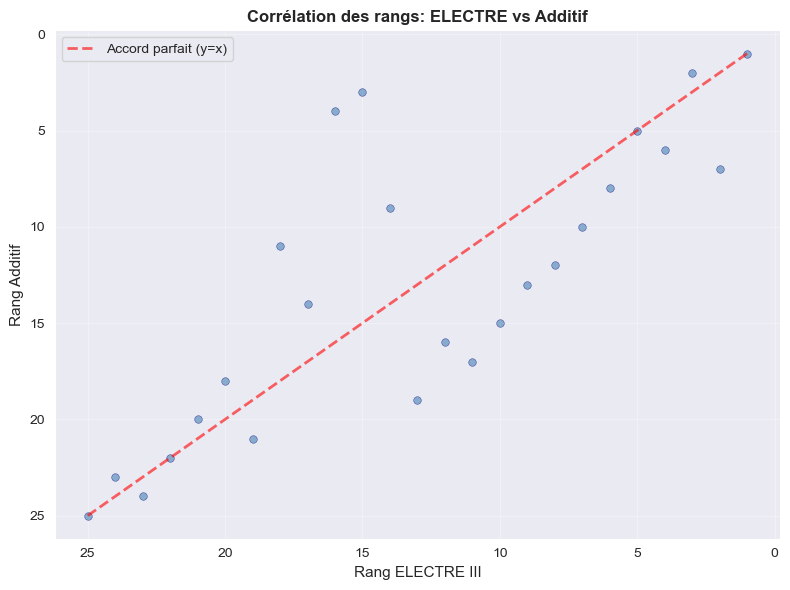


📝 Synthèse
  • Actions analysées:       25
  • Top 10 recouvrement:      7/10 (70%)
  • Corrélation Spearman:    0.781
  • Désaccords majeurs:      3

✓ Comparaison terminée.


In [39]:
# Cellule 30 - Comparaison ELECTRE III vs Additif (amélioré)
print("=" * 70)
print("⚖️  Comparaison ELECTRE III vs Méthode additive")
print("=" * 70)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, kendalltau

# Paramètres
TOP_N = 10                     # Taille des top N à comparer
SHOW_DISAGREEMENTS = True      # Afficher les désaccords majeurs
DISAGREEMENT_THRESHOLD = 5     # Écart de rangs considéré comme désaccord
EXPORT_COMP_CSV = False        # Export optionnel du tableau comparatif
COMP_CSV_PATH = "comparaison_methodes.csv"

# 1) Validation des variables requises
print("🔍 Validation des prérequis...")
required_vars = ["ranking", "score_add", "ac_work"]
missing = [v for v in required_vars if v not in globals()]

if missing:
    print(f"⚠️  Variables manquantes: {', '.join(missing)}")
    raise NameError(f"Impossible de comparer sans: {', '.join(missing)}")

# Vérifications de structure
if not isinstance(ranking, pd.DataFrame) or "phi_netflow" not in ranking.columns:
    raise ValueError("ranking doit être un DataFrame avec 'phi_netflow'")
if not isinstance(score_add, pd.DataFrame) or "score_additif" not in score_add.columns:
    raise ValueError("score_add doit être un DataFrame avec 'score_additif'")
if not isinstance(ac_work, pd.DataFrame):
    raise TypeError("ac_work doit être un DataFrame")

print("✓ Toutes les variables requises sont présentes.\n")

# 2) Analyse du recouvrement des Top N
print(f"📊 Recouvrement des Top {TOP_N}:")

# Extraire les top N de chaque méthode
top_electre = ranking.head(TOP_N)
top_add = score_add.head(TOP_N)

top_electre_ids = set(top_electre.index.astype(str))
top_add_ids = set(top_add.index.astype(str))

# Calcul des ensembles
common_top = top_electre_ids & top_add_ids
only_electre = top_electre_ids - top_add_ids
only_add = top_add_ids - top_electre_ids

print(f"  • Actions communes:        {len(common_top):>2}/{TOP_N} ({len(common_top)/TOP_N*100:.0f}%)")
print(f"  • Uniquement ELECTRE:      {len(only_electre):>2}")
print(f"  • Uniquement Additif:      {len(only_add):>2}")

# Afficher les actions communes si elles existent
if common_top and "action_id" in ac_work.columns:
    print(f"\n✅ Actions communes aux deux Top {TOP_N}:")
    ac_indexed = ac_work.set_index("action_id")
    for action_id in sorted(common_top):
        try:
            action_data = ac_indexed.loc[action_id]
            # Gérer les cas où action_id a plusieurs lignes (duplicates)
            if isinstance(action_data, pd.DataFrame):
                action_data = action_data.iloc[0]
            ville = action_data.get('ville', 'N/A')
            type_local = action_data.get('type_local', 'N/A')
            print(f"  • {action_id}: {ville} - {type_local}")
        except KeyError:
            print(f"  • {action_id}: (détails non trouvés)")

# 3) Corrélation globale des rangs
print("\n" + "=" * 70)
print("📈 Corrélation des classements (sur toutes les actions)")
print("=" * 70)

# Joindre les deux classements
comp_full = ranking.join(score_add, how='inner', rsuffix='_add')
if len(comp_full) < 2:
    print("⚠️  Trop peu d'actions communes pour calcul de corrélation.")
else:
    # Calculer les rangs
    comp_full['rang_electre'] = comp_full['phi_netflow'].rank(ascending=False, method='average')
    comp_full['rang_additif'] = comp_full['score_additif'].rank(ascending=False, method='average')
    
    # Corrélations
    try:
        rho, p_spearman = spearmanr(comp_full['rang_electre'], comp_full['rang_additif'])
        print(f"  • Spearman ρ:  {rho:.3f} (p={p_spearman:.4f})")
    except Exception as e:
        print(f"  ⚠️  Échec Spearman: {e}")
        rho = np.nan
    
    try:
        tau, p_kendall = kendalltau(comp_full['rang_electre'], comp_full['rang_additif'])
        print(f"  • Kendall τ:   {tau:.3f} (p={p_kendall:.4f})")
    except Exception as e:
        print(f"  ⚠️  Échec Kendall: {e}")
    
    # Interprétation
    if not np.isnan(rho):
        if rho >= 0.7:
            print("  ➜ Fort accord entre les deux méthodes")
        elif rho >= 0.4:
            print("  ➜ Accord modéré entre les deux méthodes")
        else:
            print("  ➜ Accord faible — désaccords importants")

# 4) Tableau comparatif (union des Top N)
print("\n" + "=" * 70)
print(f"📋 Tableau comparatif (union des Top {TOP_N})")
print("=" * 70)

top_union_ids = list(top_electre_ids | top_add_ids)

comp_table = pd.DataFrame({
    "phi_netflow": ranking["phi_netflow"],
    "score_additif": score_add["score_additif"],
}).loc[top_union_ids].copy()

# Calculer les rangs locaux (sur l'union)
comp_table["rang_electre"] = comp_table["phi_netflow"].rank(ascending=False, method="min").astype(int)
comp_table["rang_additif"] = comp_table["score_additif"].rank(ascending=False, method="min").astype(int)
comp_table["ecart_rang"] = abs(comp_table["rang_electre"] - comp_table["rang_additif"])

# Joindre les infos d'action
if "action_id" in ac_work.columns:
    ac_indexed = ac_work.set_index("action_id")
    # Colonnes à joindre (sélection dynamique)
    join_cols = []
    for c in ["ville", "type_local", "rentabilite", "cashflow", "prix_m2"]:
        if c in ac_indexed.columns:
            join_cols.append(c)
    if join_cols:
        comp_table = comp_table.join(ac_indexed[join_cols], how='left')

# Trier par rang ELECTRE
comp_table = comp_table.sort_values("rang_electre")

print(comp_table.to_string())

# 5) Analyse des désaccords
if SHOW_DISAGREEMENTS and "ecart_rang" in comp_table.columns:
    print("\n" + "=" * 70)
    print(f"⚠️  Désaccords majeurs (écart ≥ {DISAGREEMENT_THRESHOLD} rangs)")
    print("=" * 70)
    
    disagreements = comp_table[comp_table["ecart_rang"] >= DISAGREEMENT_THRESHOLD].copy()
    if len(disagreements) > 0:
        print(f"\n{len(disagreements)} action(s) avec désaccord significatif:")
        for idx, row in disagreements.iterrows():
            print(f"\n  • Action {idx}:")
            print(f"      Rang ELECTRE:  {row['rang_electre']:>2}")
            print(f"      Rang Additif:  {row['rang_additif']:>2}")
            print(f"      Écart:         {row['ecart_rang']:>2}")
            if 'ville' in row and 'type_local' in row:
                print(f"      Localisation:  {row['ville']} ({row['type_local']})")
    else:
        print(f"  ✓ Aucun désaccord majeur (écart < {DISAGREEMENT_THRESHOLD})")

# 6) Visualisation: Scatter des rangs
if len(comp_full) >= 2:
    print("\n📊 Génération du graphique de corrélation...")
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.scatter(comp_full['rang_electre'], comp_full['rang_additif'], 
               alpha=0.6, s=30, color='steelblue', edgecolors='navy', linewidth=0.4)
    
    # Ligne de référence (accord parfait)
    min_rank = min(comp_full['rang_electre'].min(), comp_full['rang_additif'].min())
    max_rank = max(comp_full['rang_electre'].max(), comp_full['rang_additif'].max())
    ax.plot([min_rank, max_rank], [min_rank, max_rank], 
            'r--', alpha=0.6, linewidth=2, label='Accord parfait (y=x)')
    
    ax.set_xlabel("Rang ELECTRE III", fontsize=11)
    ax.set_ylabel("Rang Additif", fontsize=11)
    ax.set_title("Corrélation des rangs: ELECTRE vs Additif", fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.invert_xaxis()  # Rang 1 = meilleur (à gauche)
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

# 7) Export optionnel
if EXPORT_COMP_CSV:
    try:
        comp_table.to_csv(COMP_CSV_PATH, index=True)
        print(f"\n✓ Tableau comparatif exporté: {COMP_CSV_PATH}")
    except Exception as e:
        print(f"\n⚠️  Échec export CSV: {e}")

# 8) Synthèse finale
print("\n" + "=" * 70)
print("📝 Synthèse")
print("=" * 70)
print(f"  • Actions analysées:       {len(comp_full)}")
print(f"  • Top {TOP_N} recouvrement:      {len(common_top)}/{TOP_N} ({len(common_top)/TOP_N*100:.0f}%)")
if not np.isnan(rho):
    print(f"  • Corrélation Spearman:    {rho:.3f}")
if SHOW_DISAGREEMENTS and len(disagreements) > 0:
    print(f"  • Désaccords majeurs:      {len(disagreements)}")

print("\n✓ Comparaison terminée.")

In [40]:
# Cellule 36 - Documentation des critères (améliorée)
print("=" * 70)
print("📚 Documentation des critères d'évaluation")
print("=" * 70)

import pandas as pd
import os

# Paramètres
EXPORT_META = True
META_XLSX_PATH = "electre_outputs.xlsx"
META_SHEET_NAME = "criteria_meta"

# 1) Définition structurée des critères
criteria_rows = [
    {
        "critere": "rentabilite",
        "sens": "maximiser",
        "unite": "%",
        "source": "DVF + carte des loyers (DHUP)",
        "dimension": "Financière",
        "description": "Loyer annuel / Prix d'achat × 100 (rentabilité brute)",
    },
    {
        "critere": "cashflow",
        "sens": "maximiser",
        "unite": "€/an",
        "source": "DVF + hypothèses financement",
        "dimension": "Financière",
        "description": "Loyer annuel - annuités de crédit - charges (proxy de soutenabilité)",
    },
    {
        "critere": "prix_m2",
        "sens": "minimiser",
        "unite": "€/m²",
        "source": "DVF",
        "dimension": "Financière",
        "description": "Prix d'achat / surface bâtie",
    },
    {
        "critere": "loyer_m2",
        "sens": "maximiser",
        "unite": "€/m²/mois",
        "source": "Carte des loyers (DHUP)",
        "dimension": "Financière",
        "description": "Loyer de marché par m² et par commune",
    },
    {
        "critere": "loyer_annuel",
        "sens": "maximiser",
        "unite": "€/an",
        "source": "DVF + carte des loyers (DHUP)",
        "dimension": "Financière",
        "description": "Loyer_m2 × surface × 12",
    },
    {
        "critere": "liquidite",
        "sens": "maximiser",
        "unite": "nb",
        "source": "DVF (volume ventes/ville)",
        "dimension": "Marché",
        "description": "Facilité de revente (volume de transactions DVF par ville)",
    },
    {
        "critere": "type_score",
        "sens": "maximiser",
        "unite": "0/1",
        "source": "DVF (Type local)",
        "dimension": "Profil de bien",
        "description": "1 = Appartement, 0 = Maison (préférence pour un type de bien)",
    },
    {
        "critere": "indice_quartier",
        "sens": "maximiser",
        "unite": "ratio",
        "source": "DVF + carte des loyers (DHUP)",
        "dimension": "Localisation",
        "description": "Loyer_m2 / Prix_m2 (attractivité économique du quartier)",
    },
]

CRITERIA_META = pd.DataFrame(criteria_rows)

# 2) Validation du tableau
required_cols = ["critere", "sens", "unite", "source", "dimension", "description"]
missing_cols = [c for c in required_cols if c not in CRITERIA_META.columns]
if missing_cols:
    raise ValueError(f"Colonnes manquantes dans CRITERIA_META: {missing_cols}")

# Supprimer doublons éventuels et réindexer
before = len(CRITERIA_META)
CRITERIA_META = CRITERIA_META.drop_duplicates(subset=["critere"]).reset_index(drop=True)
after = len(CRITERIA_META)
if after < before:
    print(f"ℹ️  {before - after} doublon(s) de critère supprimé(s)")

# Ordonner les colonnes pour lisibilité
CRITERIA_META = CRITERIA_META[required_cols]

print("\nDocumentation des critères d'évaluation:\n")
print(CRITERIA_META.to_string(index=False))

# 3) Export optionnel dans le classeur Excel
if EXPORT_META:
    try:
        mode = "a" if os.path.exists(META_XLSX_PATH) else "w"
        with pd.ExcelWriter(META_XLSX_PATH, engine="openpyxl", mode=mode, if_sheet_exists="replace") as writer:
            CRITERIA_META.to_excel(writer, sheet_name=META_SHEET_NAME, index=False)
        print(f"\n✓ Métadonnées écrites dans '{META_XLSX_PATH}' (feuille '{META_SHEET_NAME}')")
    except Exception as e:
        print(f"\n⚠️  Échec de l'export des métadonnées: {e}")

CRITERIA_META

📚 Documentation des critères d'évaluation

Documentation des critères d'évaluation:

        critere      sens     unite                        source      dimension                                                          description
    rentabilite maximiser         % DVF + carte des loyers (DHUP)     Financière                Loyer annuel / Prix d'achat × 100 (rentabilité brute)
       cashflow maximiser      €/an  DVF + hypothèses financement     Financière Loyer annuel - annuités de crédit - charges (proxy de soutenabilité)
        prix_m2 minimiser      €/m²                           DVF     Financière                                         Prix d'achat / surface bâtie
       loyer_m2 maximiser €/m²/mois       Carte des loyers (DHUP)     Financière                                Loyer de marché par m² et par commune
   loyer_annuel maximiser      €/an DVF + carte des loyers (DHUP)     Financière                                              Loyer_m2 × surface × 12
      liquidite

,critere,sens,unite,source,dimension,description
0,rentabilite,maximiser,%,DVF + carte des loyers (DHUP),Financière,Loyer annuel / Prix d'achat × 100 (rentabilité...
1,cashflow,maximiser,€/an,DVF + hypothèses financement,Financière,Loyer annuel - annuités de crédit - charges (p...
2,prix_m2,minimiser,€/m²,DVF,Financière,Prix d'achat / surface bâtie
3,loyer_m2,maximiser,€/m²/mois,Carte des loyers (DHUP),Financière,Loyer de marché par m² et par commune
4,loyer_annuel,maximiser,€/an,DVF + carte des loyers (DHUP),Financière,Loyer_m2 × surface × 12
5,liquidite,maximiser,nb,DVF (volume ventes/ville),Marché,Facilité de revente (volume de transactions DV...
6,type_score,maximiser,0/1,DVF (Type local),Profil de bien,"1 = Appartement, 0 = Maison (préférence pour u..."
7,indice_quartier,maximiser,ratio,DVF + carte des loyers (DHUP),Localisation,Loyer_m2 / Prix_m2 (attractivité économique du...


In [41]:
# Cellule 37 - Résumé de l'analyse (amélioré)
print("=" * 70)
print("                     RÉSUMÉ DE L'ANALYSE                     ")
print("=" * 70)

import pandas as pd
import numpy as np

# Paramètres
LAMBDA_BASE = 0.6

# 1) Validation des variables clés
required_dfs = {
    "ac": "DataFrame des actions initiales",
    "ac_work": "DataFrame des actions utilisées pour ELECTRE",
    "ranking": "Classement net flow ELECTRE",
    "noyau": "Actions du noyau",
}
missing = []
for name, desc in required_dfs.items():
    if name not in globals():
        missing.append(f"{name} ({desc})")
    else:
        obj = globals()[name]
        if not isinstance(obj, pd.DataFrame):
            missing.append(f"{name} (doit être DataFrame)")

if missing:
    print("⚠️  Variables manquantes ou invalides pour le résumé:")
    for m in missing:
        print(f"   - {m}")
    raise NameError("Résumé interrompu: variables manquantes/invalides.")

# ac_pareto fallback
if 'ac_pareto' not in globals() or not isinstance(globals().get('ac_pareto'), pd.DataFrame):
    print("ac_pareto non défini - utilisation de ac comme fallback")
    ac_pareto = ac.copy()

# 2) Statistiques générales
print(f"  • Liquidité moyenne (ac_work):     {ac_work['liquidite'].mean():>9.0f}")
print(f"  • Indice_quartier moyen (ac_work): {ac_work['indice_quartier'].mean():>9.3f}")

print("\nDONNÉES TRAITÉES:")
nb_ac = len(ac)
nb_pareto = len(ac_pareto)
nb_work = len(ac_work)
print(f"  • Actions IDF analysées:           {nb_ac:>10,}")
print(f"  • Front de Pareto:                 {nb_pareto:>10,} ({(nb_pareto/nb_ac*100 if nb_ac else 0):.1f}%)")
print(f"  • Actions pour ELECTRE III:        {nb_work:>10,}")

# 3) Résultats ELECTRE III
print("\nRÉSULTATS ELECTRE III:")
if 'phi_netflow' in ranking.columns and len(ranking) > 0:
    phi_mean = ranking['phi_netflow'].mean()
    phi_max = ranking['phi_netflow'].max()
    phi_min = ranking['phi_netflow'].min()
    print(f"  • Taille du noyau (λ={LAMBDA_BASE}): {len(noyau_ids):>10,} ({(len(noyau_ids)/nb_work*100 if nb_work else 0):.1f}%)")
    print(f"  • Score net flow moyen:            {phi_mean:>10.2f}")
    print(f"  • Score net flow max:              {phi_max:>10.2f}")
    print(f"  • Score net flow min:              {phi_min:>10.2f}")
else:
    print("  • phi_netflow indisponible dans ranking")

# 4) Statistiques du noyau
print("\nSTATISTIQUES DU NOYAU:")
if len(noyau) > 0:
    print(f"  • Rentabilité moyenne:             {noyau['rentabilite'].mean():>9.2f}%")
    print(f"  • Cash-flow moyen:                 {noyau['cashflow'].mean():>9.0f} €/an")
    print(f"  • Prix/m² moyen:                   {noyau['prix_m2'].mean():>9.0f} €/m²")
else:
    print("  • Noyau vide – consultez plutôt le classement net flow (Top 10)")
    print("    Cela peut refléter des critères très conflictuels ou des seuils (q,p,v) exigeants.")

# 5) Statistiques globales ac_work
print("\nSTATISTIQUES GLOBALES (ac_work):")
print(f"  • Rentabilité moyenne:             {ac_work['rentabilite'].mean():>9.2f}%")
print(f"  • Cash-flow moyen:                 {ac_work['cashflow'].mean():>9.0f} €/an")
print(f"  • Prix/m² moyen:                   {ac_work['prix_m2'].mean():>9.0f} €/m²")

# 6) Détails noyau (si non vide)
if len(noyau) > 0:
    print("\nTOP 5 VILLES DANS LE NOYAU:")
    top_villes = noyau['ville'].value_counts().head(5)
    for i, (ville, count) in enumerate(top_villes.items(), 1):
        print(f"  {i}. {ville:<30} {count:>4} actions")

    print("\nRÉPARTITION PAR TYPE DE BIEN (noyau):")
    type_repartition = noyau['type_local'].value_counts()
    for type_bien, count in type_repartition.items():
        pct = count / len(noyau) * 100
        print(f"  • {type_bien:<20} {count:>4} ({pct:>5.1f}%)")

    print("\nPLAGES DE VALEURS (noyau):")
    print(f"  • Rentabilité:   [{noyau['rentabilite'].min():>6.2f}% - {noyau['rentabilite'].max():>6.2f}%]")
    print(f"  • Cash-flow:     [{noyau['cashflow'].min():>8.0f}€ - {noyau['cashflow'].max():>8.0f}€]")
    print(f"  • Prix/m²:       [{noyau['prix_m2'].min():>8.0f}€ - {noyau['prix_m2'].max():>8.0f}€]")
else:
    print("\nAucune statistique détaillée disponible pour le noyau vide.")

print("\n" + "=" * 70)

                     RÉSUMÉ DE L'ANALYSE                     
  • Liquidité moyenne (ac_work):            58
  • Indice_quartier moyen (ac_work):     0.013

DONNÉES TRAITÉES:
  • Actions IDF analysées:               11,565
  • Front de Pareto:                         25 (0.2%)
  • Actions pour ELECTRE III:                25

RÉSULTATS ELECTRE III:
  • Taille du noyau (λ=0.6):          3 (12.0%)
  • Score net flow moyen:                  0.00
  • Score net flow max:                   16.73
  • Score net flow min:                   -9.25

STATISTIQUES DU NOYAU:
  • Rentabilité moyenne:                 24.12%
  • Cash-flow moyen:                     33643 €/an
  • Prix/m² moyen:                        1599 €/m²

STATISTIQUES GLOBALES (ac_work):
  • Rentabilité moyenne:                 15.91%
  • Cash-flow moyen:                     18964 €/an
  • Prix/m² moyen:                        2440 €/m²

TOP 5 VILLES DANS LE NOYAU:
  1. ORLY                              1 actions
  2. VILLE-D'AVRAY

In [42]:
# Cellule 38 - Export des résultats prudents & comparaison (amélioré)
print("=" * 70)
print("📤 Export des résultats de l'analyse prudente")
print("=" * 70)

import pandas as pd
import numpy as np
import os

# Paramètres
EXPORT_PRUDENT = True
PRUDENT_XLSX_PATH = "electre_outputs.xlsx"

# 1) Validation des variables nécessaires
required_vars = {
    "ac_work": "DataFrame des actions (travail)",
    "noyau_ids_prudent": "IDs du noyau prudent",
    "sigma_prudent": "Matrice σ (prudent)",
    "ranking_prudent": "Classement prudent (phi_netflow)",
    "synth": "Synthèse base (pour comparaison)",
}
missing = []
for v, desc in required_vars.items():
    if v not in globals():
        missing.append(v)
    else:
        if v == "ac_work" and not isinstance(ac_work, pd.DataFrame):
            missing.append("ac_work (doit être DataFrame)")
        if v == "sigma_prudent" and not isinstance(sigma_prudent, pd.DataFrame):
            missing.append("sigma_prudent (doit être DataFrame)")
        if v == "ranking_prudent" and not isinstance(ranking_prudent, pd.DataFrame):
            missing.append("ranking_prudent (doit être DataFrame)")

if missing:
    print("⚠️  Variables manquantes pour l'export prudent:")
    for m in missing:
        print(f"   - {m}")
    raise NameError(f"Export prudent interrompu: {', '.join(missing)}")

# 2) Construction du noyau prudent DataFrame
try:
    ac_idx = ac_work.set_index("action_id")
    noyau_prudent = ac_idx.loc[noyau_ids_prudent].reset_index()
    print(f"✓ Noyau prudent construit ({len(noyau_prudent)} actions)")
except Exception as e:
    print(f"❌ Échec construction noyau prudent: {e}")
    raise

# 3) Export Excel (append/replace)
if EXPORT_PRUDENT:
    try:
        mode = "a" if os.path.exists(PRUDENT_XLSX_PATH) else "w"
        with pd.ExcelWriter(PRUDENT_XLSX_PATH, engine="openpyxl", mode=mode, if_sheet_exists="replace") as writer:
            sigma_prudent.to_excel(writer, sheet_name="sigma_prudent")
            ranking_prudent.to_excel(writer, sheet_name="ranking_prudent")
            noyau_prudent.to_excel(writer, sheet_name="noyau_prudent", index=False)
        print(f"✓ Résultats 'prudent' ajoutés à '{PRUDENT_XLSX_PATH}'")
        print("  • sigma_prudent: Matrice de crédibilité")
        print("  • ranking_prudent: Classement net flow")
        print("  • noyau_prudent: Actions du noyau")
    except Exception as e:
        print(f"❌ Erreur lors de l'export: {e}")

# 4) Construction de synth_prudent (si absent)
if 'synth_prudent' not in globals() or not isinstance(synth_prudent, pd.DataFrame):
    synth_prudent = ac_idx.copy()
    synth_prudent["phi_netflow_prudent"] = ranking_prudent["phi_netflow"]
    synth_prudent["is_in_noyau_prudent"] = synth_prudent.index.isin(noyau_ids_prudent)
    print("✓ synth_prudent construit pour la comparaison")

# 5) Comparaison base vs prudent
print("\n🔍 Analyse de la sensibilité (base vs prudent):")

# Vérifier que synth existe
if 'synth' not in globals() or not isinstance(synth, pd.DataFrame):
    raise NameError("La synthèse de base 'synth' est requise pour comparer base/prudent.")

cols_compare = [
    "ville", "type_local", "rentabilite", "cashflow",
    "prix_m2", "liquidite", "indice_quartier",
    "phi_netflow", "is_in_noyau"
]
cols_compare = [c for c in cols_compare if c in synth.columns]

synth_compare = synth[cols_compare].join(
    synth_prudent[["phi_netflow_prudent", "is_in_noyau_prudent"]],
    how="inner"
)

synth_compare["diff_netflow"] = synth_compare["phi_netflow_prudent"] - synth_compare["phi_netflow"]
synth_compare["changement_noyau"] = synth_compare["is_in_noyau"] != synth_compare["is_in_noyau_prudent"]

nb_change = synth_compare["changement_noyau"].sum()
corr_netflow = synth_compare["phi_netflow"].corr(synth_compare["phi_netflow_prudent"])

print(f"  • Actions avec changement de statut (noyau): {nb_change}")
print(f"  • Corrélation des net flows (base vs prudent): {corr_netflow:.3f}")

print("\nTop 20 actions (base) avec comparaison base/prudent:")
print(synth_compare.sort_values("phi_netflow", ascending=False).head(20).to_string())

print("\n✓ Export et comparaison prudent terminés.")

📤 Export des résultats de l'analyse prudente
✓ Noyau prudent construit (3 actions)
✓ Résultats 'prudent' ajoutés à 'electre_outputs.xlsx'
  • sigma_prudent: Matrice de crédibilité
  • ranking_prudent: Classement net flow
  • noyau_prudent: Actions du noyau
✓ synth_prudent construit pour la comparaison

🔍 Analyse de la sensibilité (base vs prudent):
  • Actions avec changement de statut (noyau): 3
  • Corrélation des net flows (base vs prudent): 1.000

Top 20 actions (base) avec comparaison base/prudent:
                                    ville   type_local  rentabilite  cashflow  prix_m2  liquidite  indice_quartier  phi_netflow  is_in_noyau  phi_netflow_prudent  is_in_noyau_prudent  diff_netflow  changement_noyau
action_id                                                                                                                                                                                                             
nan_23/05/2025_107               PARIS 07  Appartement       